In [1]:
import pandas as pd
import numpy as np
from replay_trajectory_classification import Environment


def load_alison_data():
    path = "/cumulus/edeno/spyglass/notebooks/test_decoding/non_local_alison/"
    animal_date = "j1620210710"

    position_info = pd.read_pickle(path + f"{animal_date}_position_info.pkl")
    linear_position_info = pd.read_pickle(path + f"{animal_date}_linear_position.pkl")

    spikes = pd.read_pickle(path + f"{animal_date}_spikes.pkl")
    env = Environment.load_environment(path + f"{animal_date}_env.pkl")

    time = np.asarray(position_info.index)
    spikes = np.asarray(spikes).astype(float)
    position = np.asarray(linear_position_info.linear_position).astype(float)
    is_ripple = np.zeros_like(position, dtype=bool)
    speed = np.asarray(position_info.head_speed).astype(float)

    not_nan = np.logical_and(~np.isnan(position), ~np.isnan(speed))

    return (
        is_ripple[not_nan],
        spikes[not_nan],
        position[not_nan],
        speed[not_nan],
        env,
        time[not_nan],
    )

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/home/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
is_ripple, spikes, position, speed, env, time = load_alison_data()

In [3]:
from src.test_non_local_switching_non_stationary_model import (
    setup_nonlocal_switching_model,
)

(
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    continuous_state_transitions,
    state_ind,
    zero_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    speed,
    env,
    no_spike_rate_threshold=0.01,
    is_stationary_discrete_transition=True,
    include_no_spike_state=True,
    emission_knot_spacing=8.0,
)

/home/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/replay_trajectory_classification/continuous_state_transitions.py:23: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)


Text(0.5, 1.0, 'Discrete State Transition')

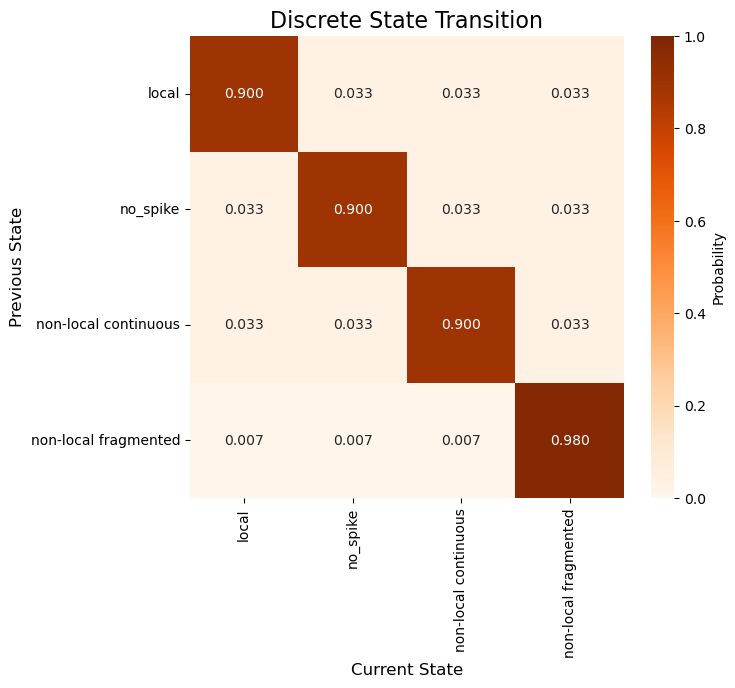

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

vmin, vmax, fmt = 0.0, 1.0, "0.03f"
label = "Probability"
cmap = "Oranges"

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(
    data=discrete_state_transitions,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=fmt,
    cmap=cmap,
    xticklabels=state_names,
    yticklabels=state_names,
    ax=ax,
    cbar_kws={"label": label},
)
ax.set_ylabel("Previous State", fontsize=12)
ax.set_xlabel("Current State", fontsize=12)
ax.set_title("Discrete State Transition", fontsize=16)

In [5]:
# log_likelihood = np.load("log_likelihood.npy")

In [6]:
from src.test_non_local_switching_non_stationary_model import fit_switching_model
import numpy as np

stickiness = np.array([30.0, 100_000.0, 30.0, 1000.0])[:, np.newaxis]

(
    predicted_state,
    acausal_posterior,
    acausal_state_probabilities,
    causal_posterior,
    marginal_log_likelihoods,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    non_local_rates,
    log_likelihood,
) = fit_switching_model(
    spikes,
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    continuous_state_transitions,
    state_ind,
    zero_rates,
    is_training,
    env,
    discrete_transition_coefficients=discrete_transition_coefficients,
    discrete_transition_design_matrix=discrete_transition_design_matrix,
    max_iter=20,
    fit_inital_conditions=True,
    fit_discrete_transition=True,
    fit_likelihood=False,
    concentration=1.1,
    stickiness=stickiness,
    # log_likelihood=log_likelihood,
)

[[0.9        0.03333333 0.03333333 0.03333333]
 [0.03333333 0.9        0.03333333 0.03333333]
 [0.03333333 0.03333333 0.9        0.03333333]
 [0.00666667 0.00666667 0.00666667 0.98      ]]
Likelihoods


  0%|          | 0/130 [00:00<?, ?it/s]

Expectation Step


/home/edeno/Documents/Github/test_hmm/src/test_non_local_switching_non_stationary_model.py:862: RuntimeWarning: invalid value encountered in divide
  acausal_posterior[t + 1] / predictive_distribution[t + 1],


Maximization Step
Stats
iteration 1, likelihood: -3039010.018438305
[[0.94887673 0.01842242 0.0279048  0.00479606]
 [0.04011882 0.93395243 0.02142529 0.00450346]
 [0.03951917 0.02334895 0.93014765 0.00698422]
 [0.03324411 0.01849681 0.02487192 0.92338716]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 2, likelihood: -3017472.2986099273, change: 21537.719828377478
[[0.95961898 0.01334371 0.02539139 0.00164592]
 [0.03751732 0.94766818 0.01354109 0.0012734 ]
 [0.03931547 0.01748908 0.93994605 0.0032494 ]
 [0.060511   0.02544749 0.0406954  0.87334611]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 3, likelihood: -3014964.9673747574, change: 2507.3312351698987
[[9.63589615e-01 1.09657338e-02 2.47088199e-02 7.35831659e-04]
 [3.40013437e-02 9.55782452e-01 9.72687348e-03 4.89330375e-04]
 [3.64908860e-02 1.35488001e-02 9.48097317e-01 1.86299734e-03]
 [7.36953057e-02 2.67984142e-02 4.80265590e-02 8.51479721e-01]]
Likelihoods
Expectation Step
Maximization Step
St

In [7]:
# np.save("log_likelihood.npy", log_likelihood)
# np.save("non_local_rates.npy", non_local_rates)

In [8]:
# non_local_rates = np.load("non_local_rates.npy")

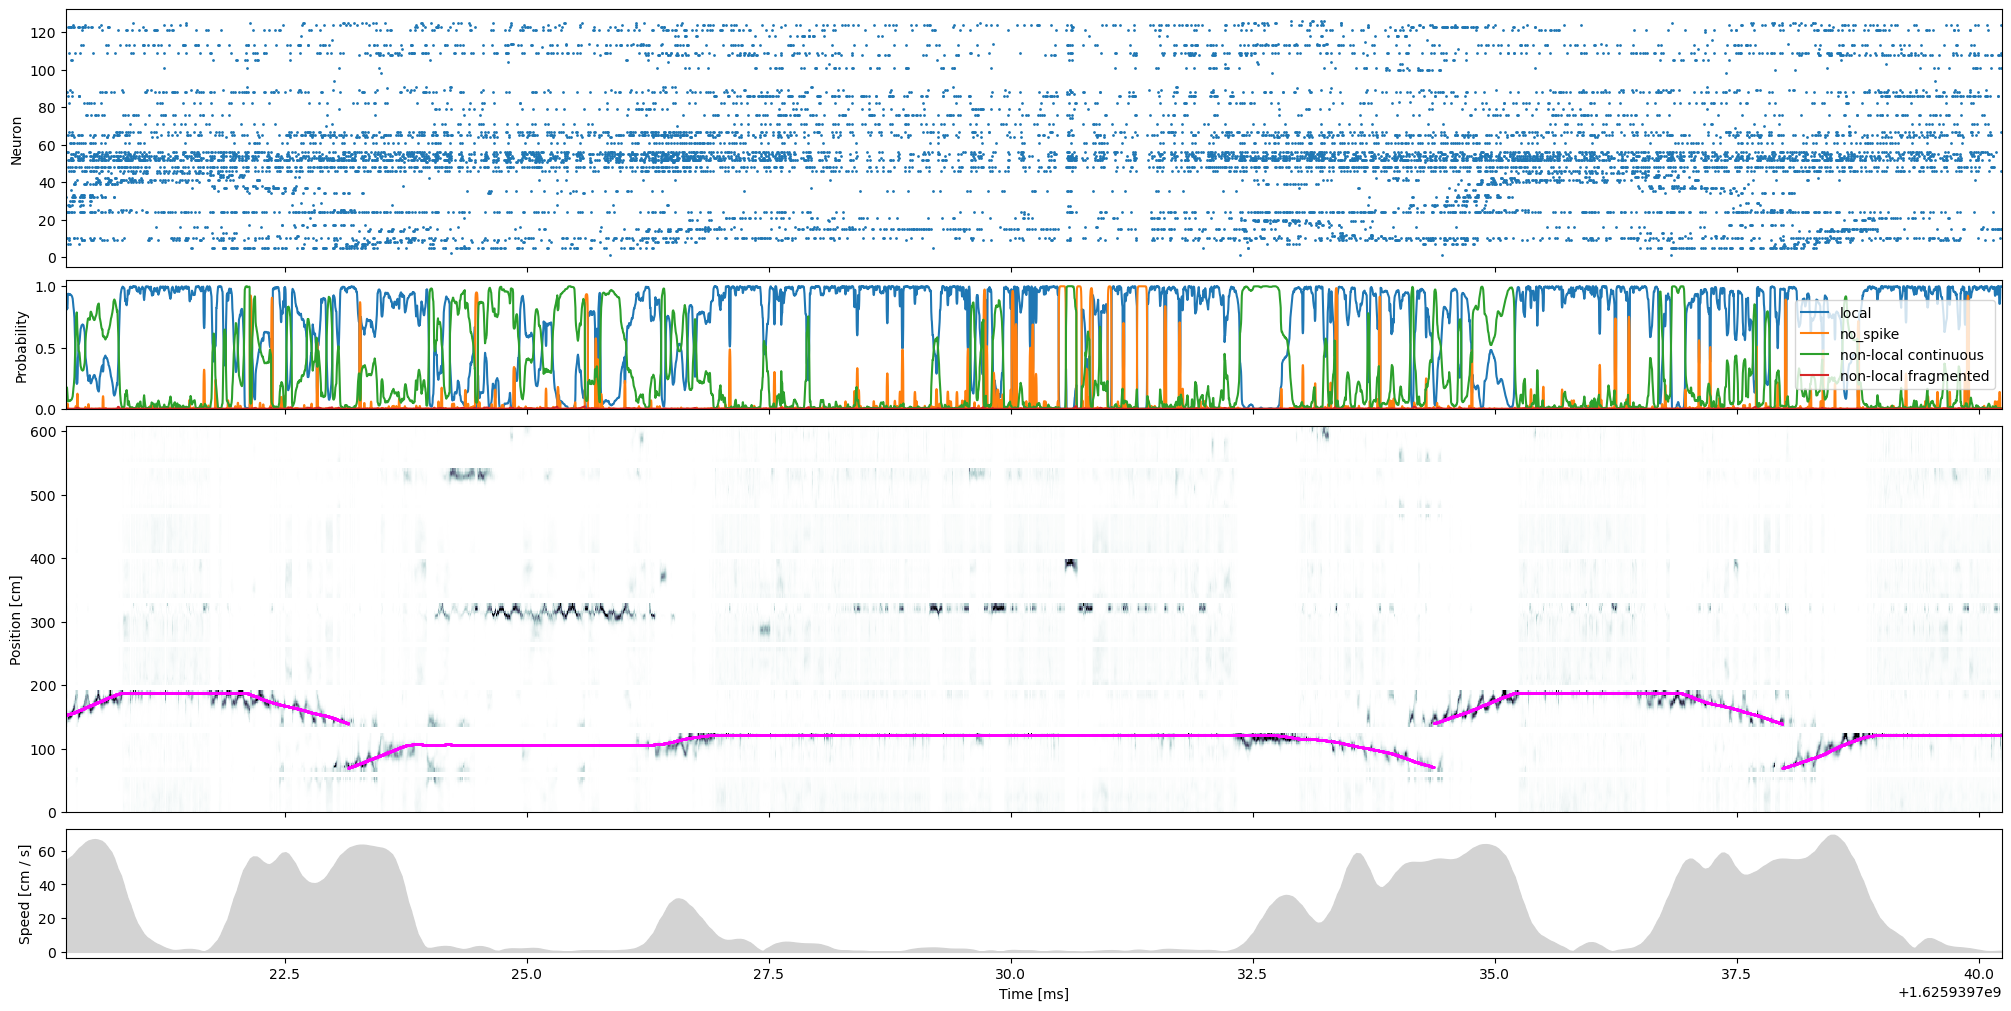

In [9]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(100_000, 110_000),
    figsize=(20, 10),
)

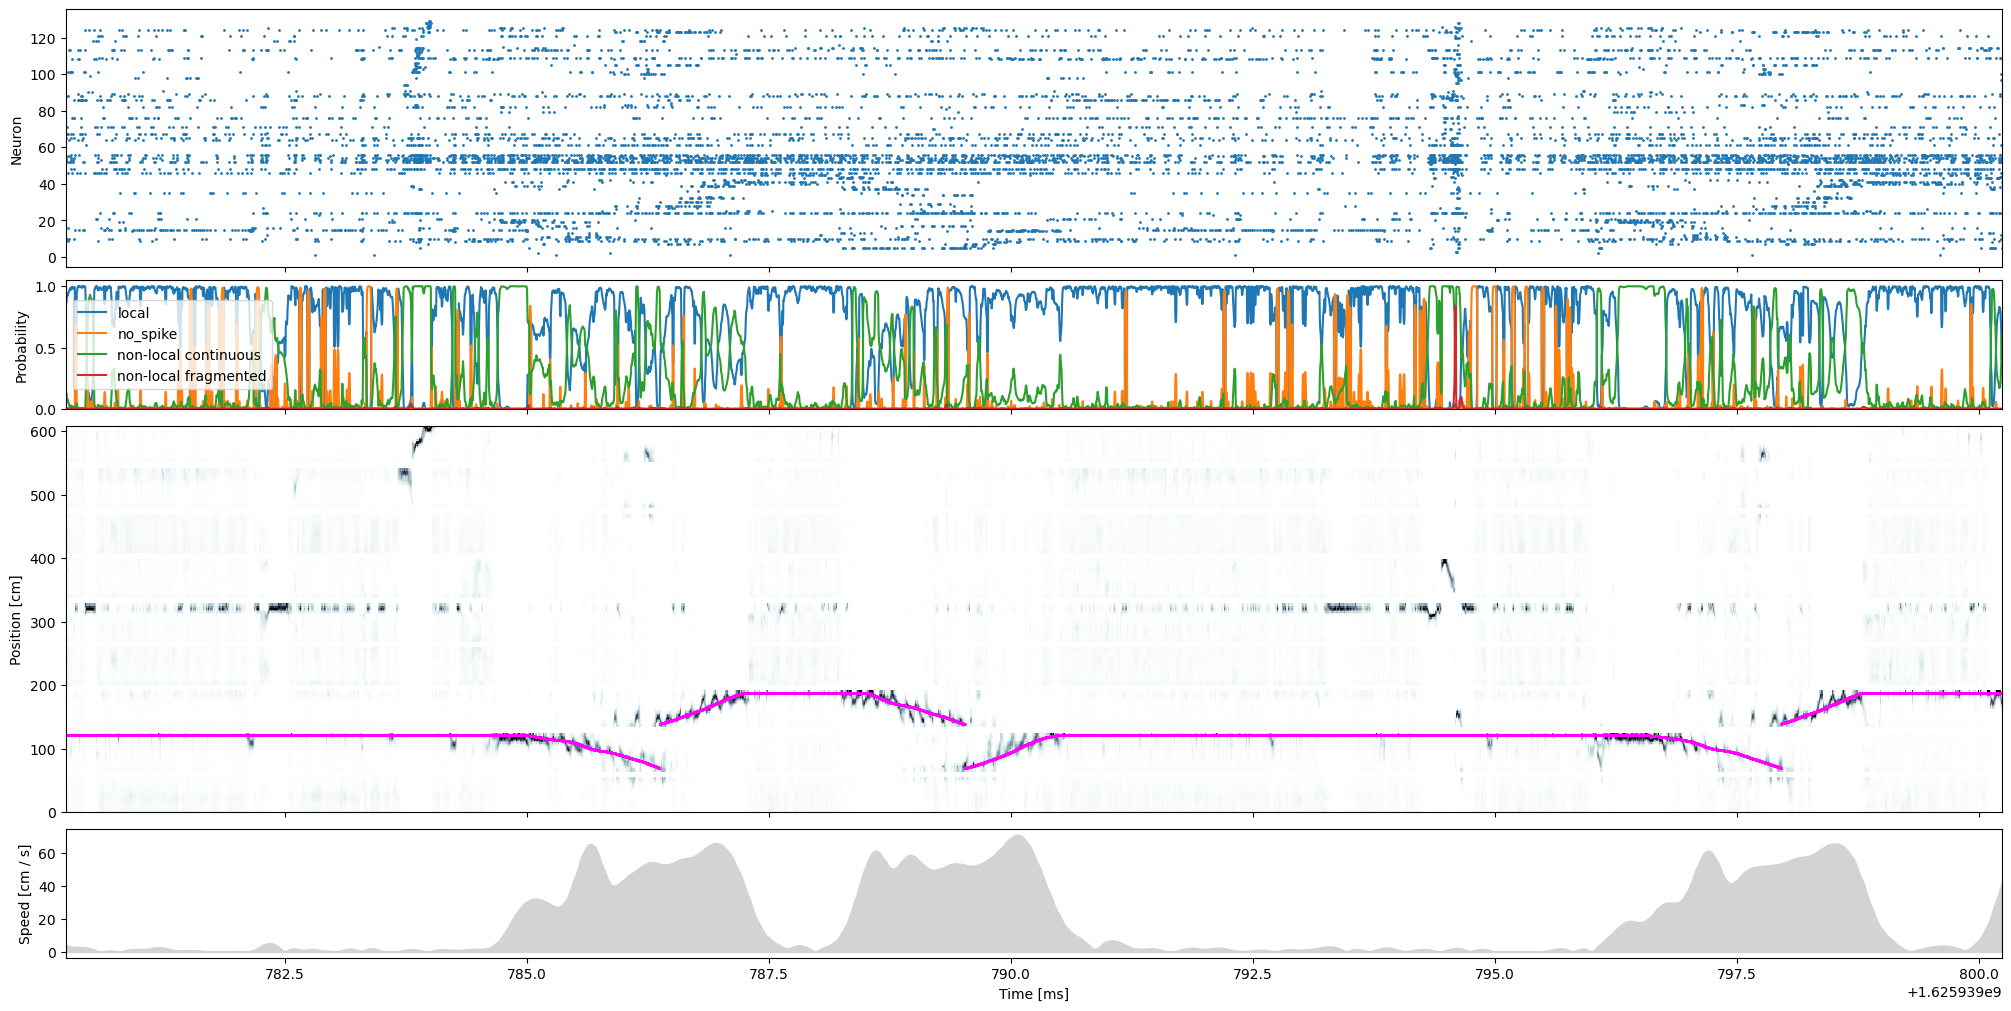

In [10]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(130_000, 140_000),
    figsize=(20, 10),
)

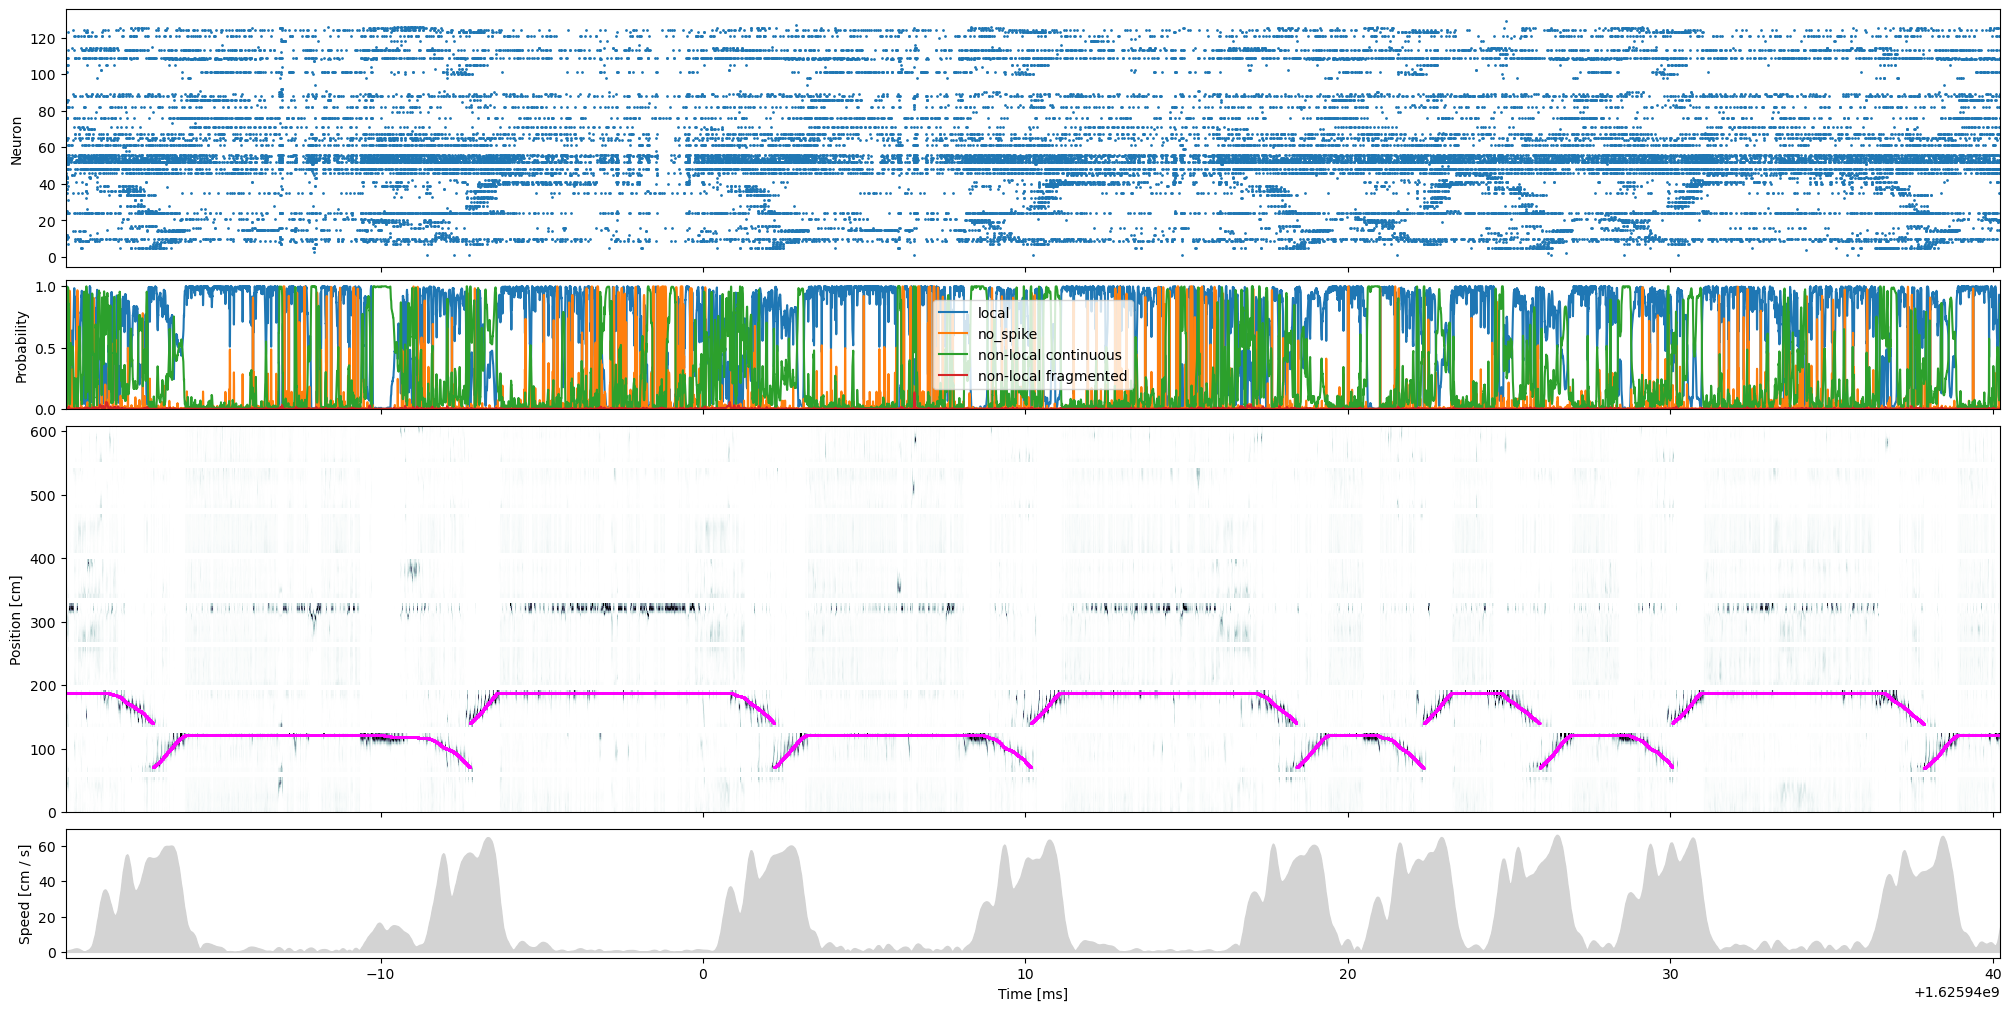

In [11]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(230_000, 260_000),
    figsize=(20, 10),
)

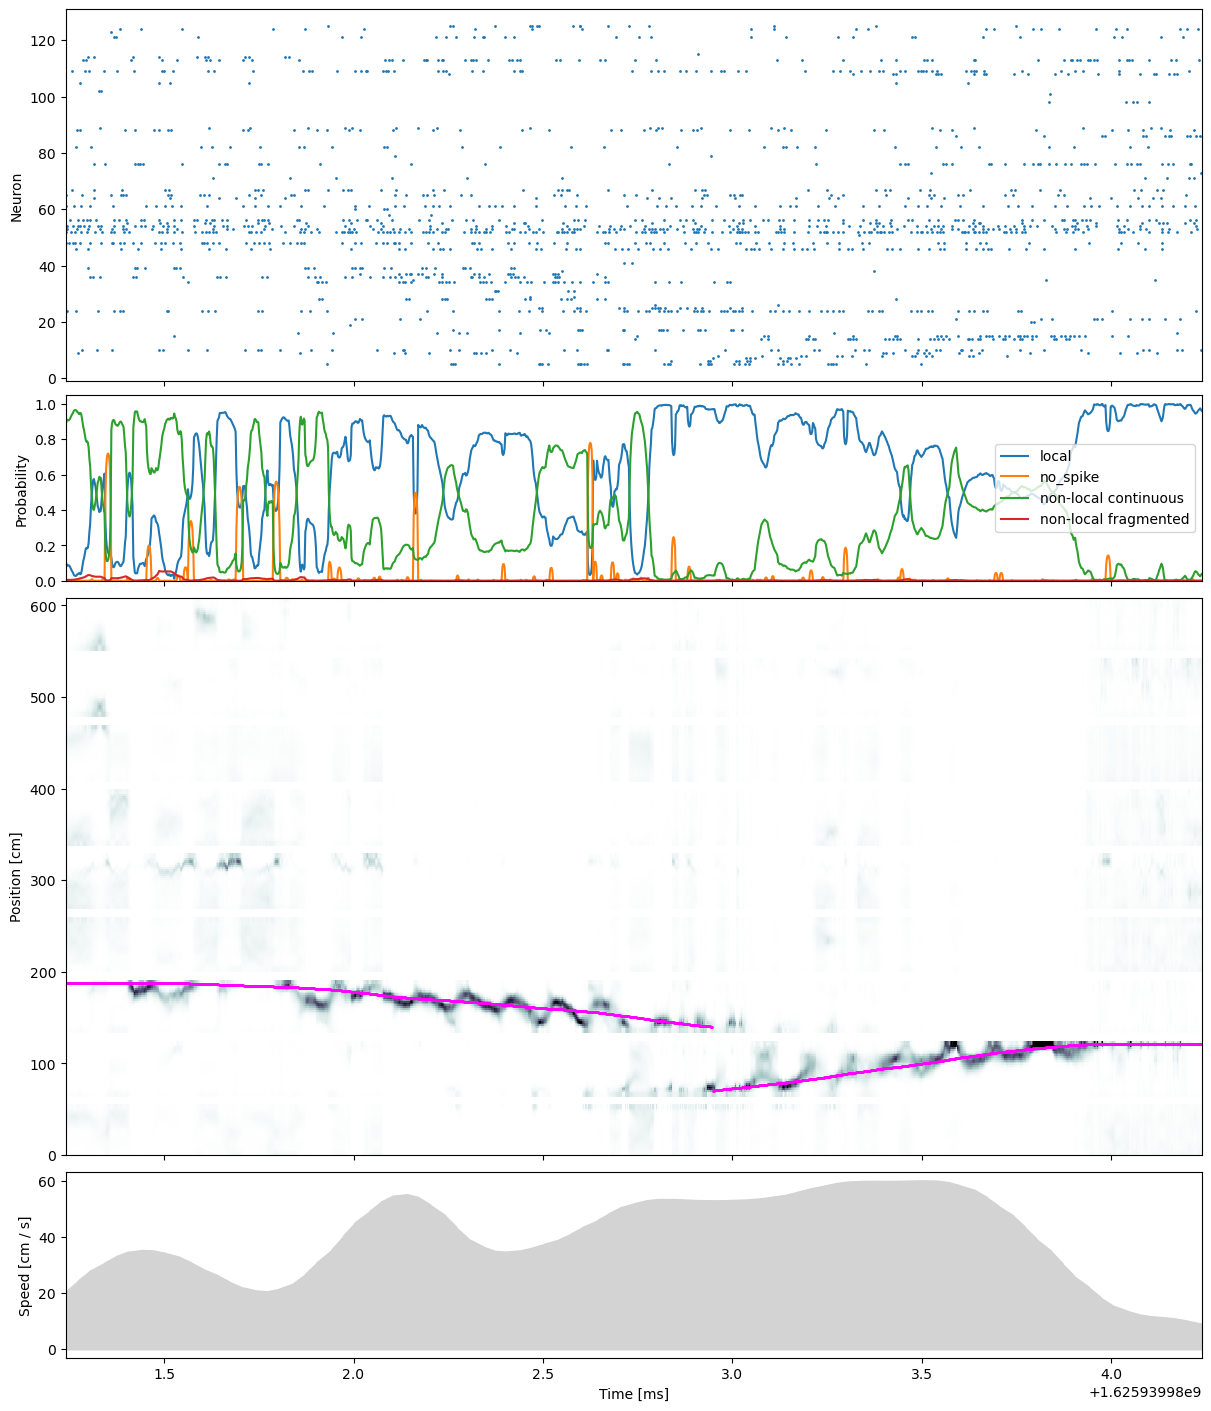

In [12]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(230_500, 232_000),
    figsize=(12, 14),
)

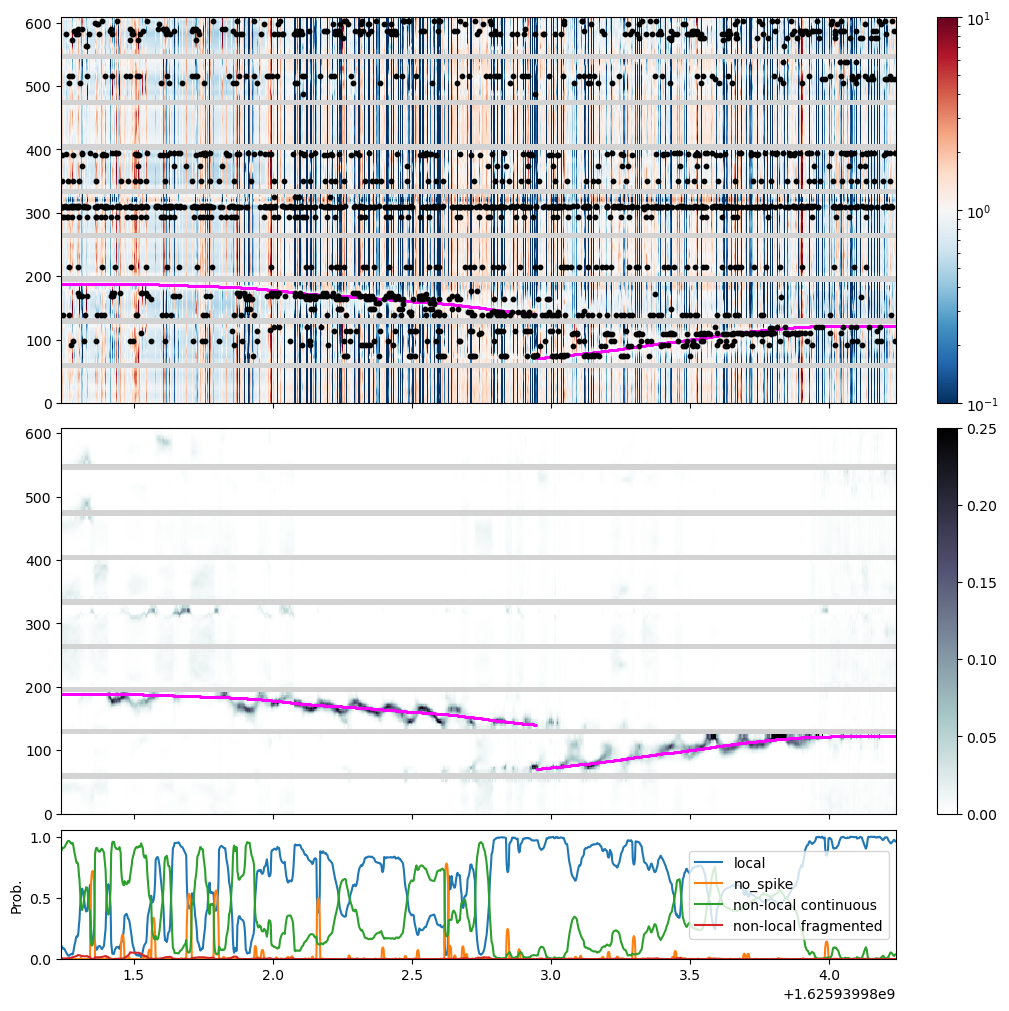

In [13]:
from src.test_non_local_switching_non_stationary_model import plot_likelihood_ratio

time_slice = slice(230_500, 232_000)


plot_likelihood_ratio(
    time_slice,
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

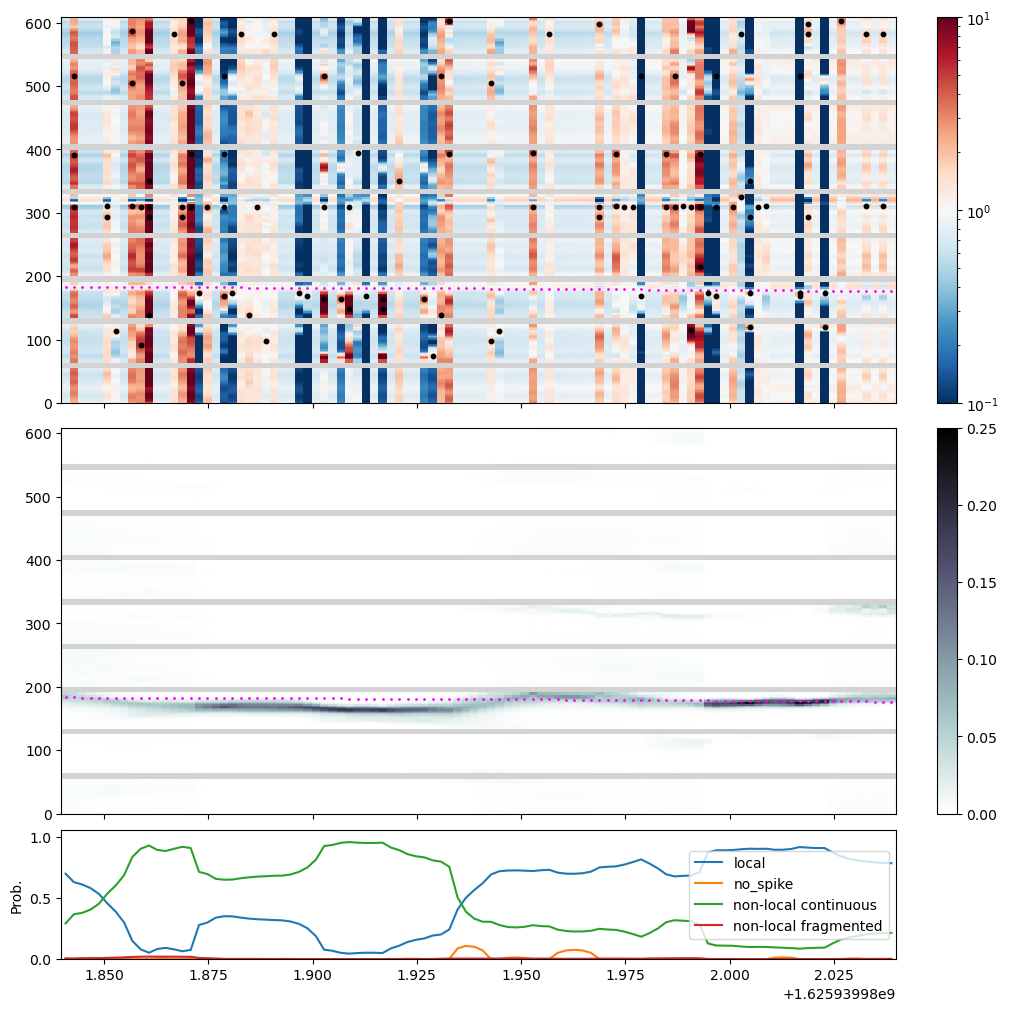

In [14]:
time_slice = slice(230_800, 230_900)

plot_likelihood_ratio(
    time_slice,
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

In [15]:
causal_state_probabilities = np.zeros_like(acausal_state_probabilities)
for state_id in range(len(state_names)):
    causal_state_probabilities[:, state_id] = causal_posterior[:, state_ind == state_id].sum(axis=1)

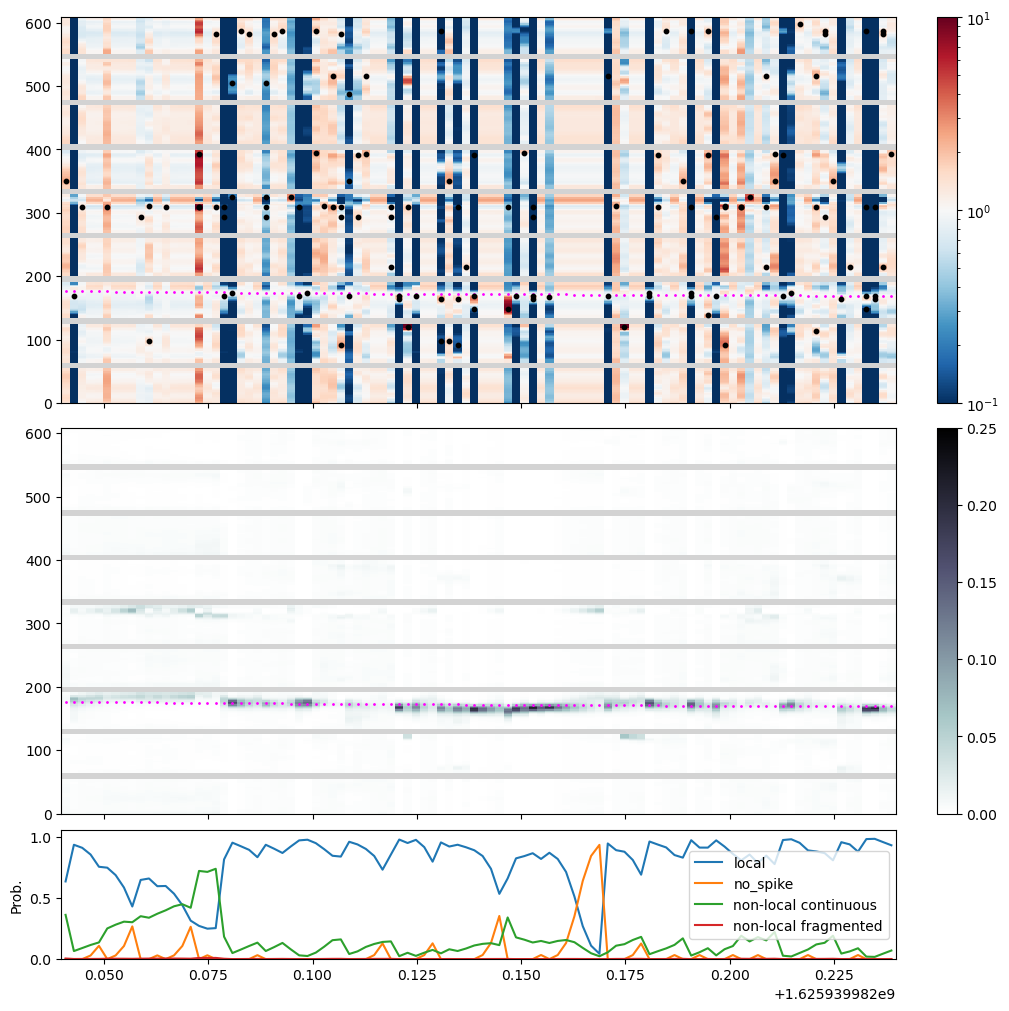

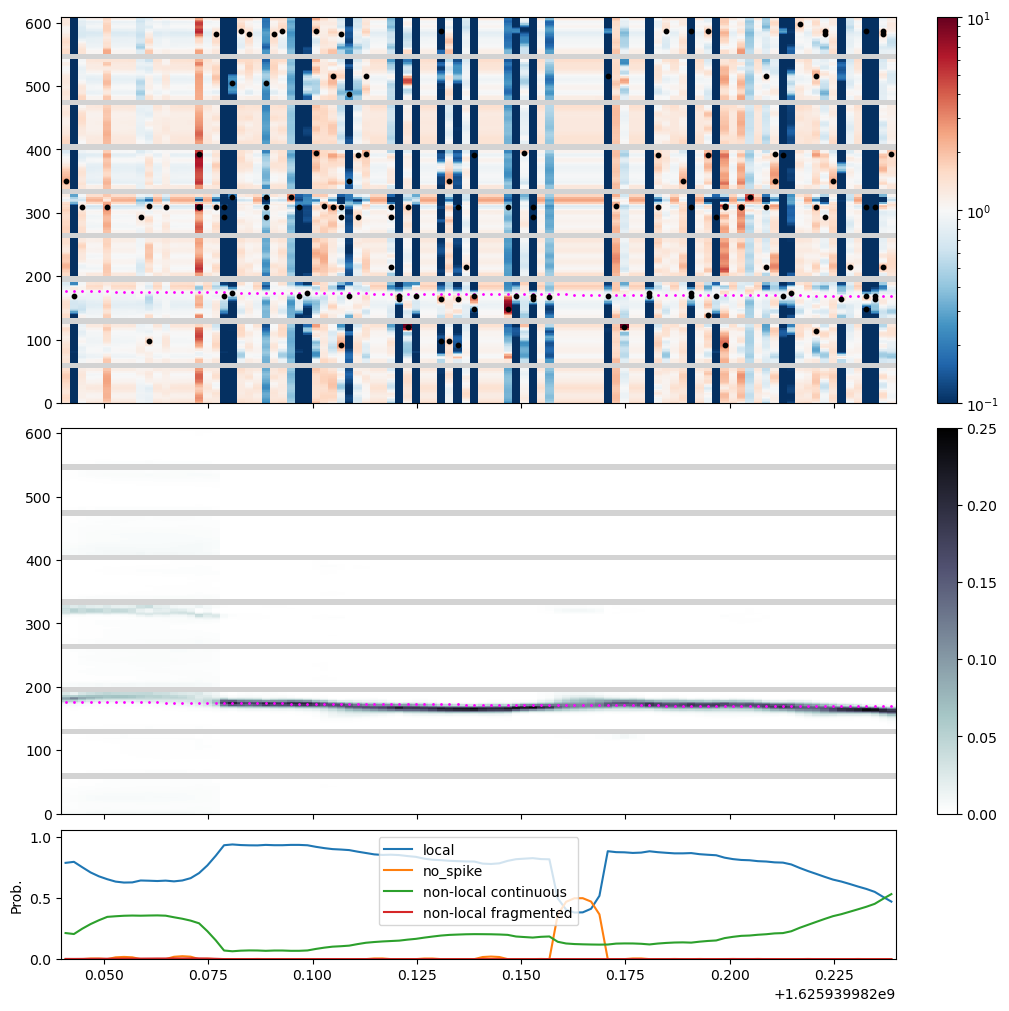

In [16]:
plot_likelihood_ratio(
    slice(230_900, 231_000),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)
plot_likelihood_ratio(
    slice(230_900, 231_000),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

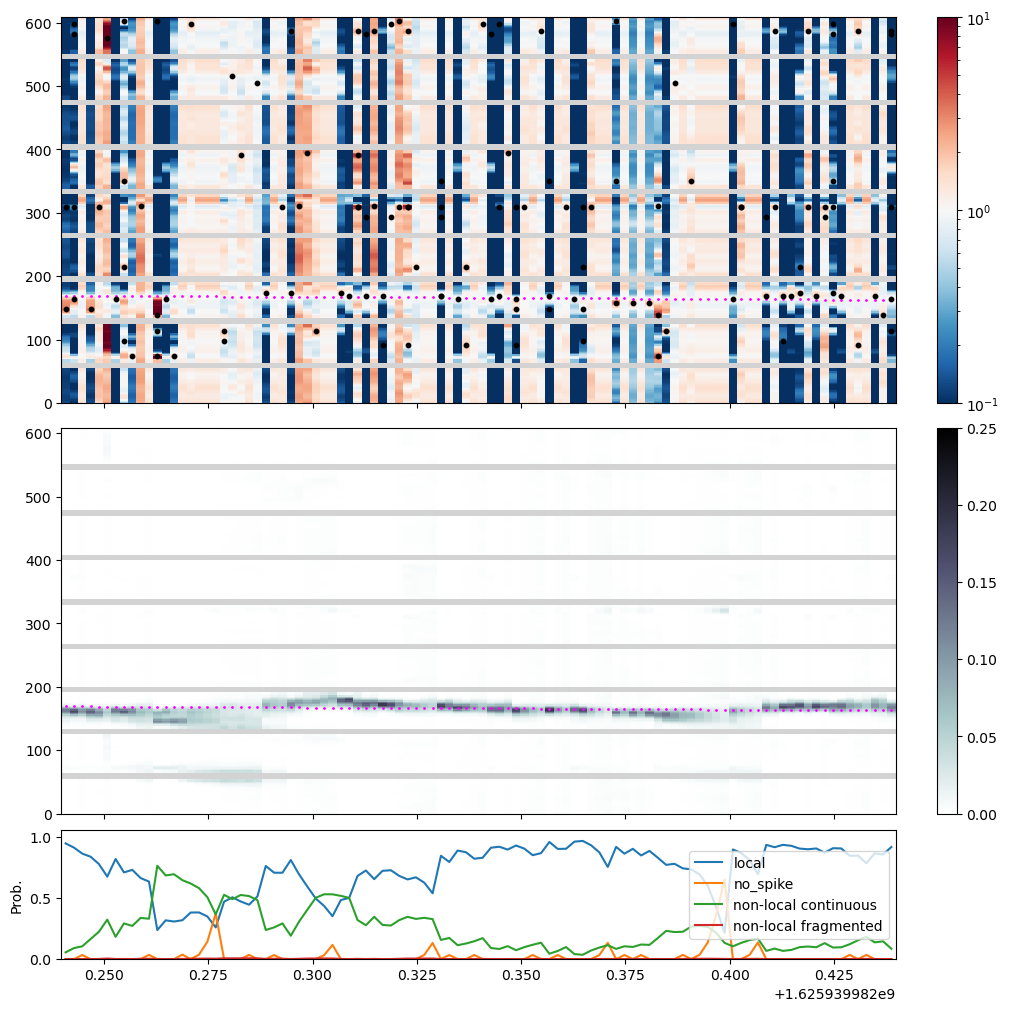

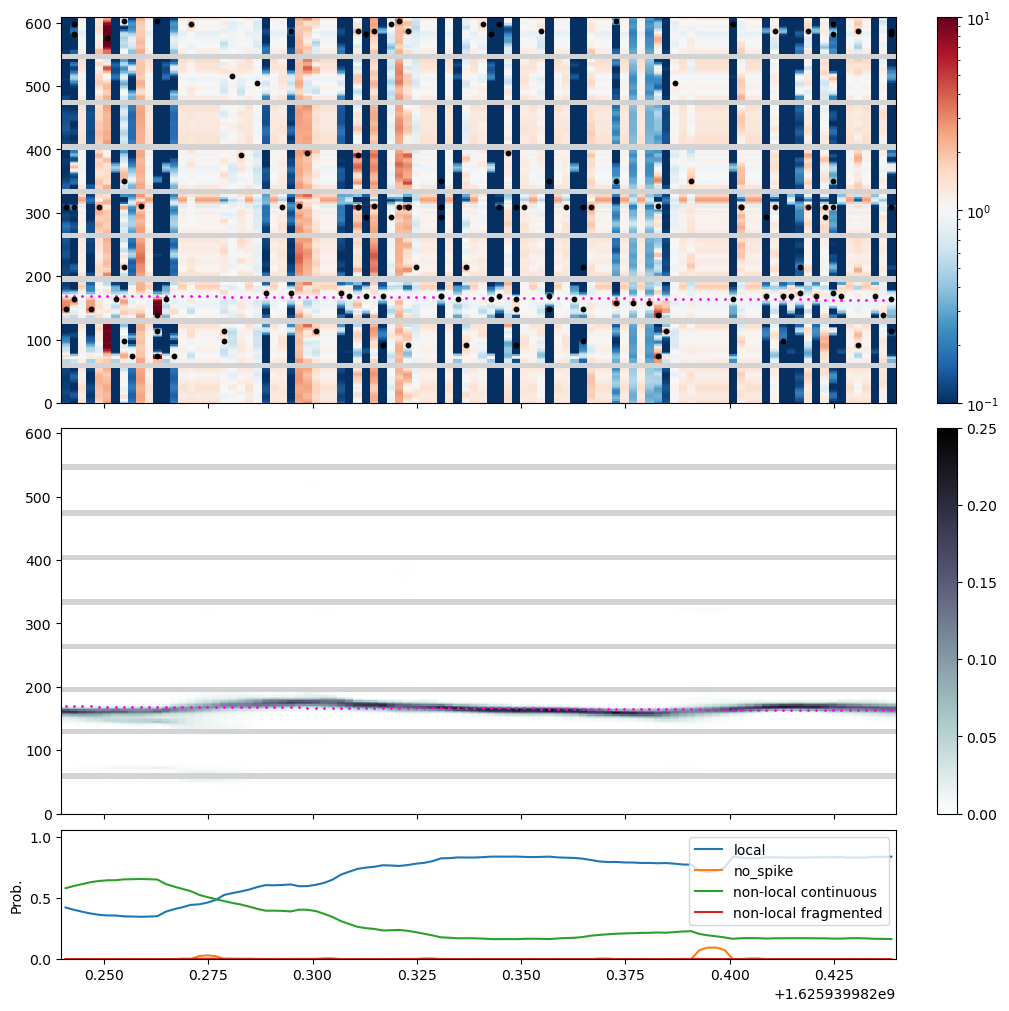

In [17]:
plot_likelihood_ratio(
    slice(231_000, 231_100),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)
plot_likelihood_ratio(
    slice(231_000, 231_100),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

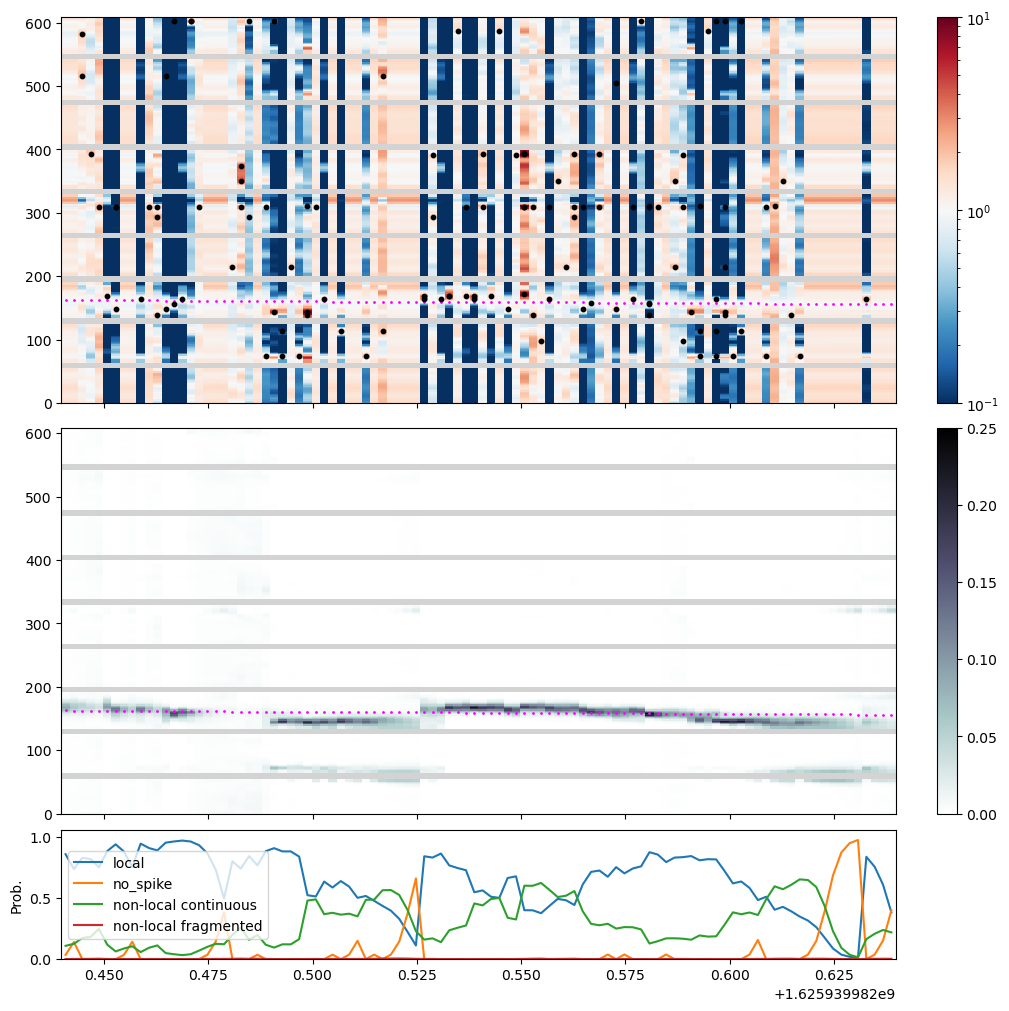

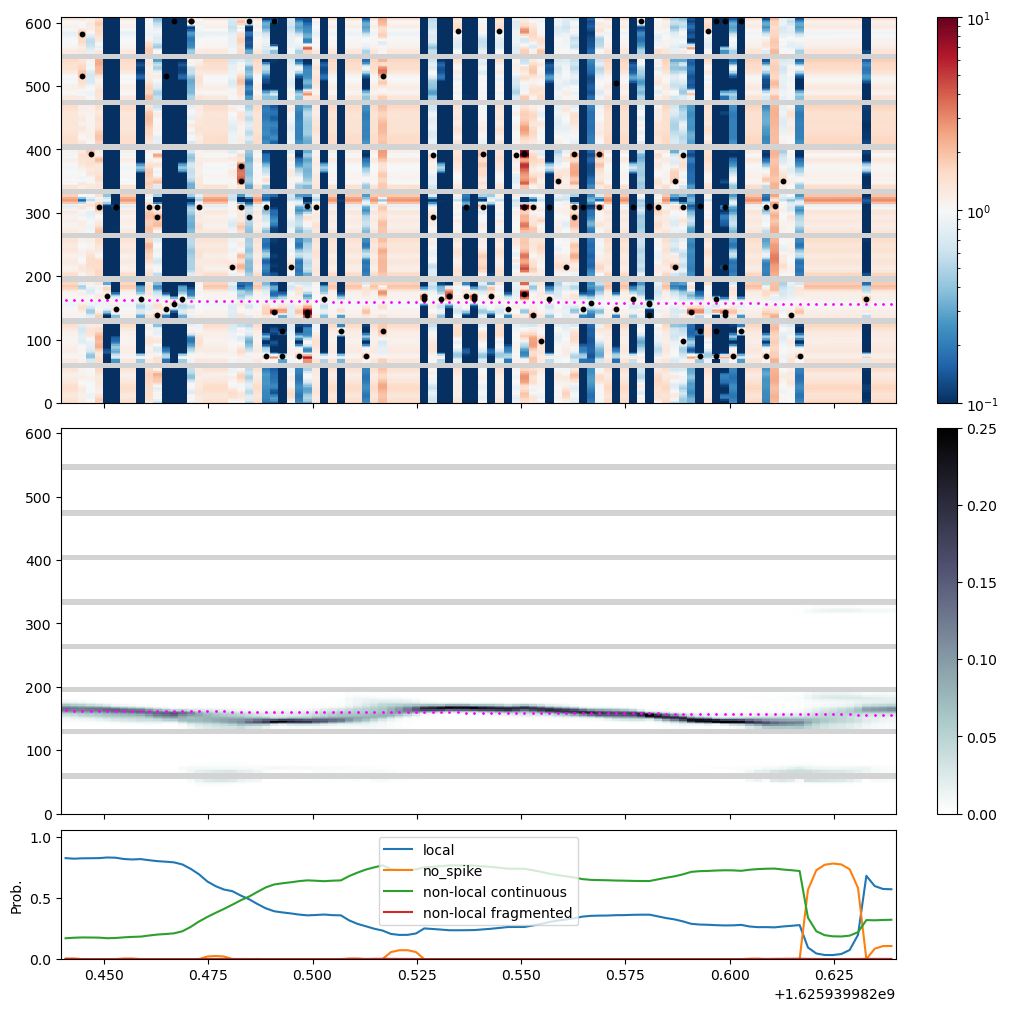

In [18]:
plot_likelihood_ratio(
    slice(231_100, 231_200),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)
plot_likelihood_ratio(
    slice(231_100, 231_200),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

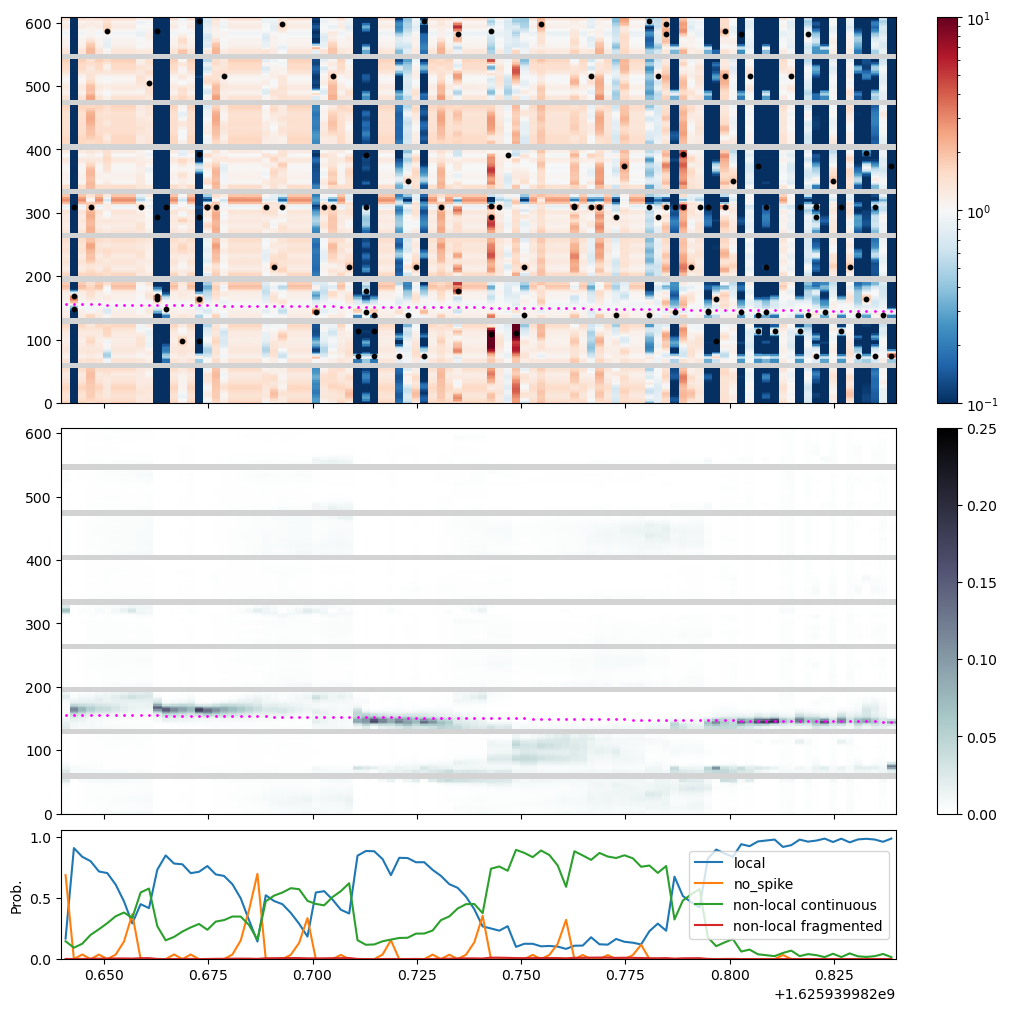

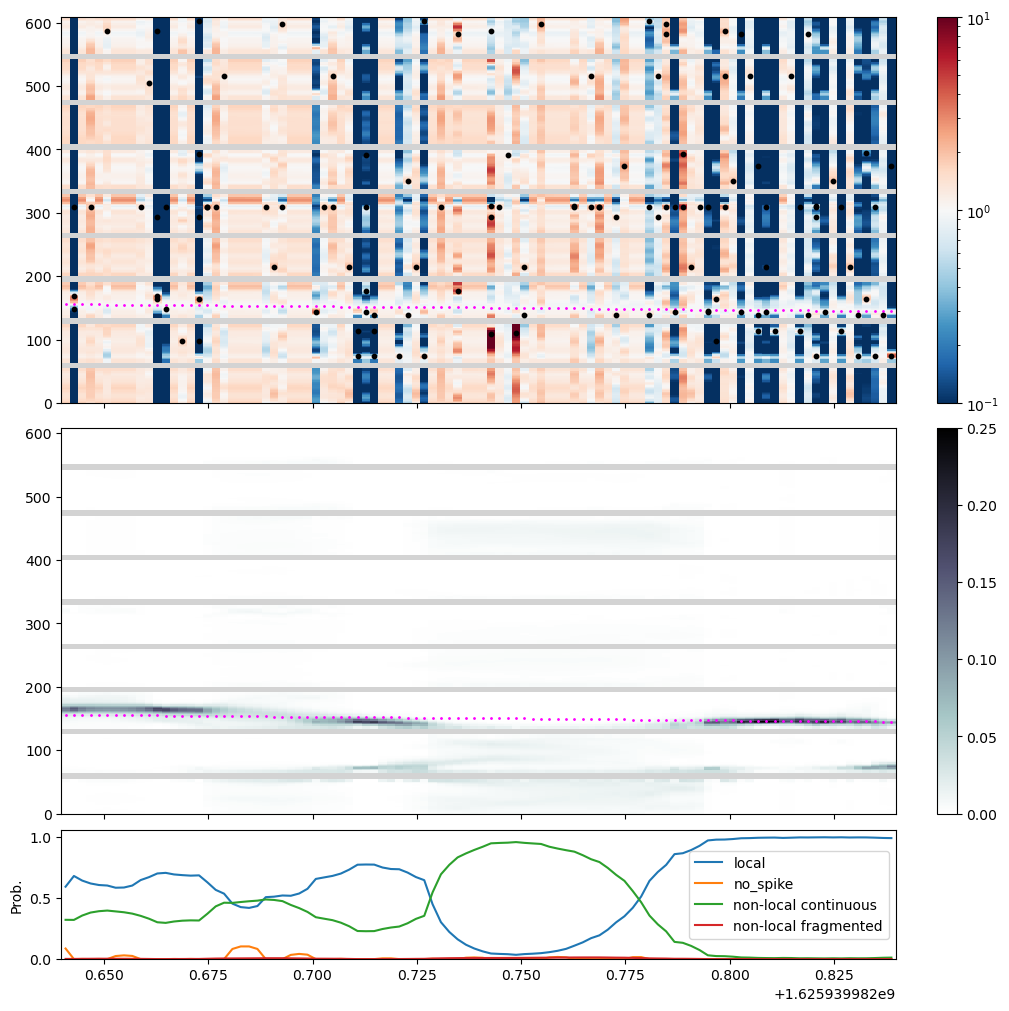

In [19]:
plot_likelihood_ratio(
    slice(231_200, 231_300),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)
plot_likelihood_ratio(
    slice(231_200, 231_300),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

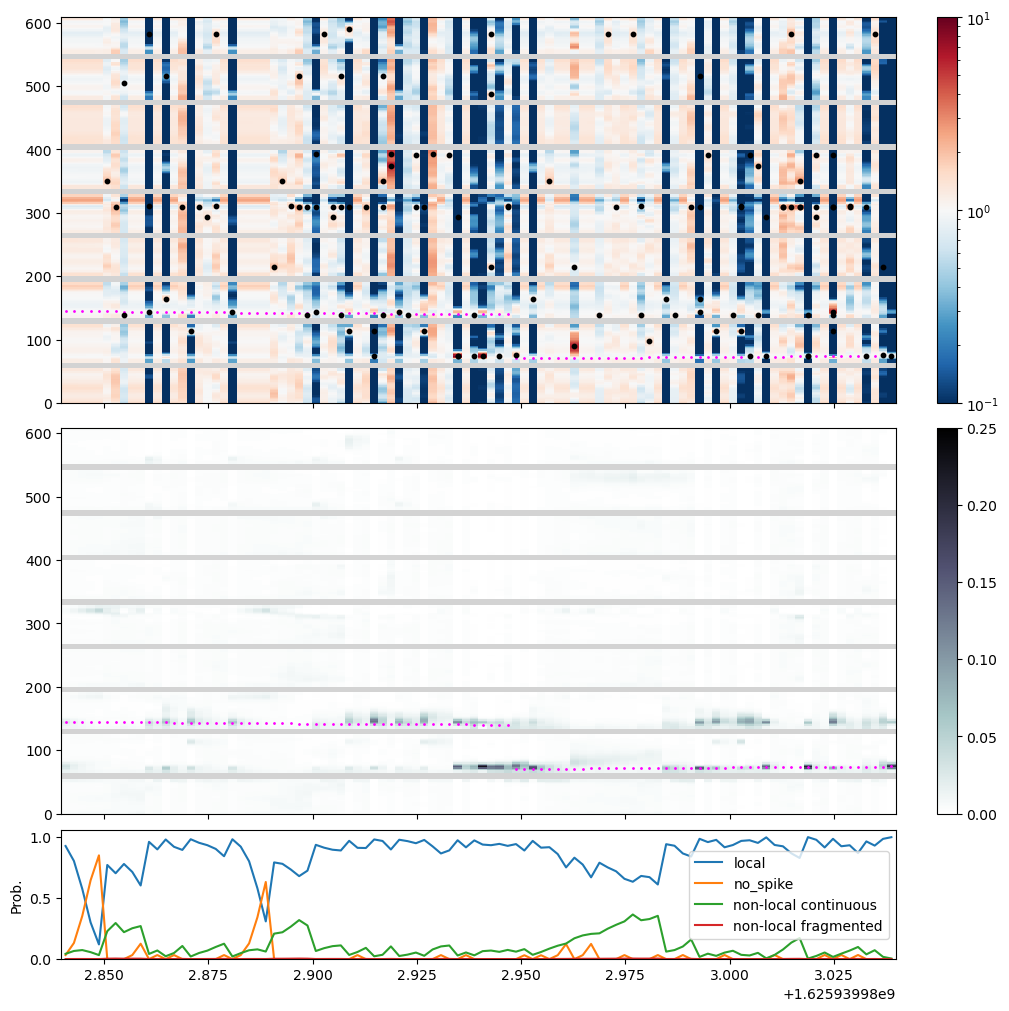

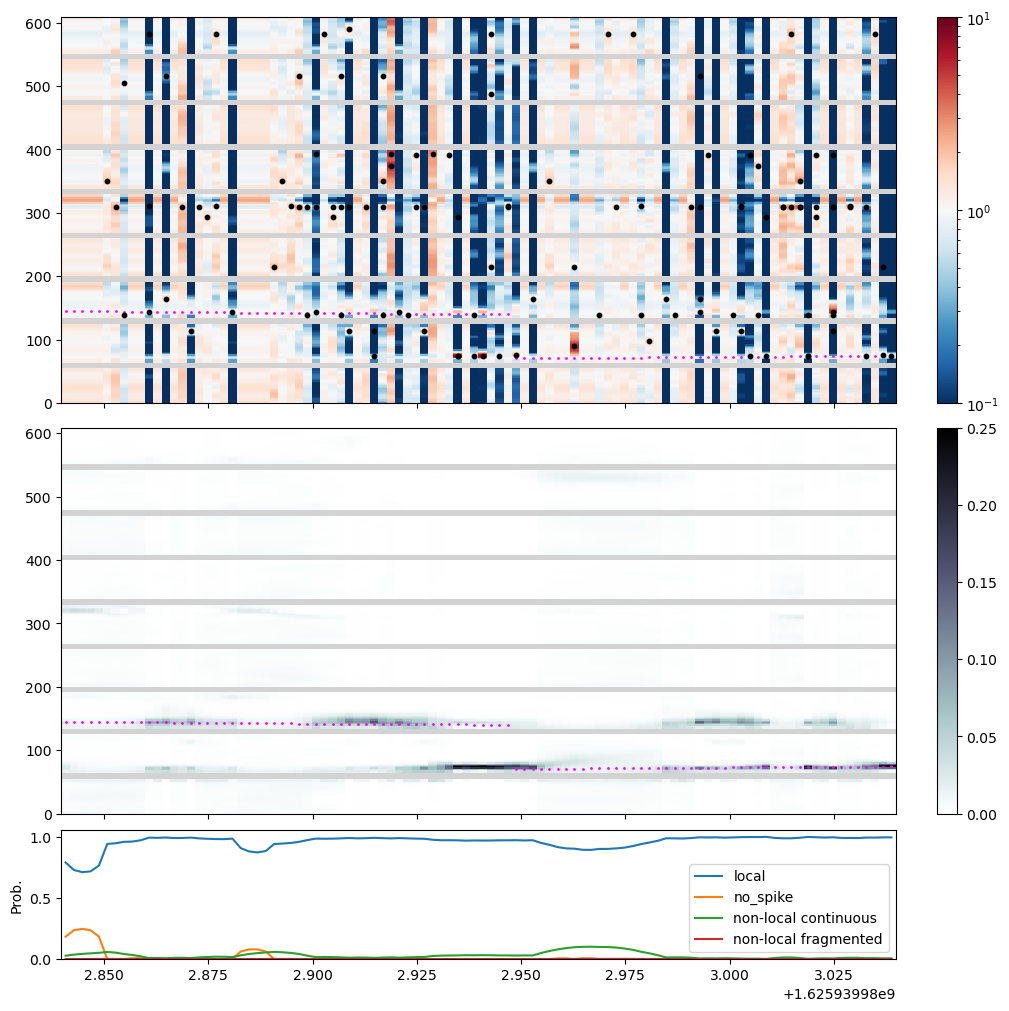

In [20]:
plot_likelihood_ratio(
    slice(231_300, 231_400),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    slice(231_300, 231_400),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

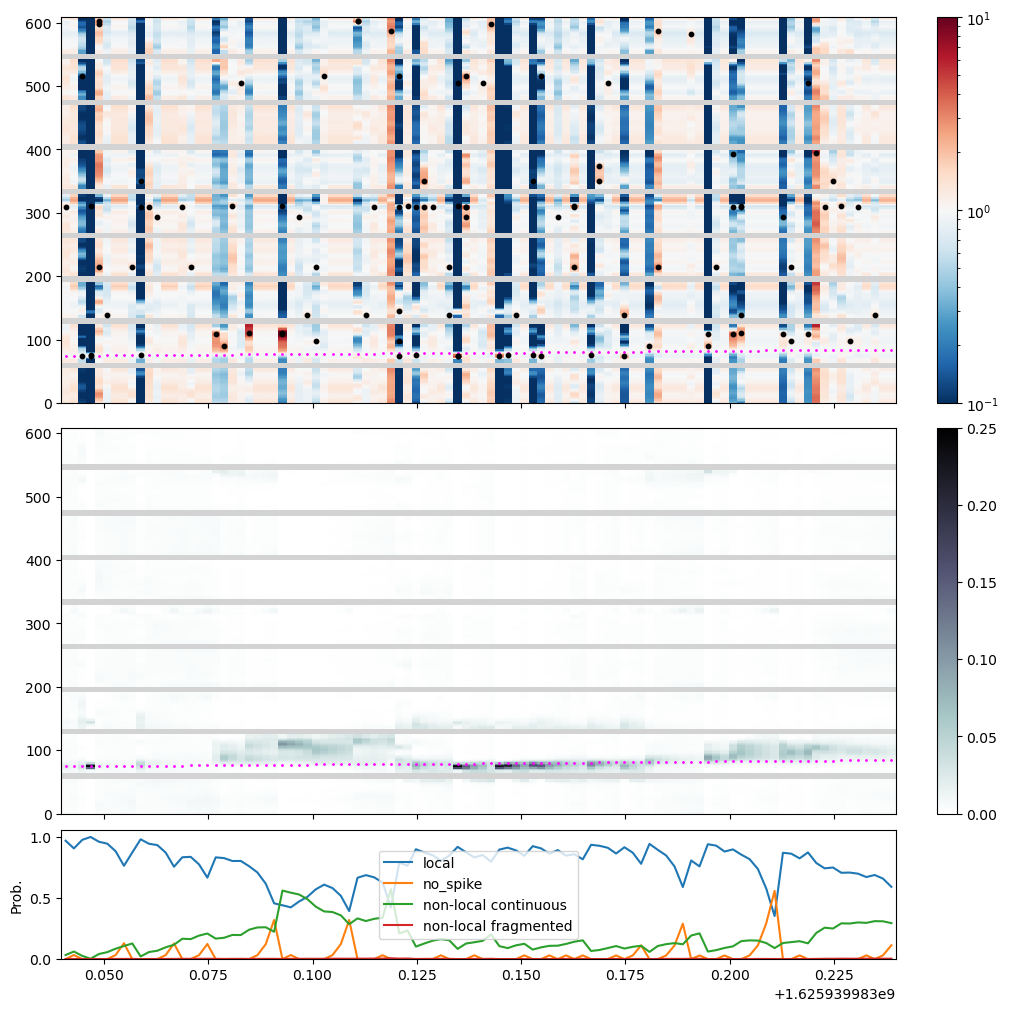

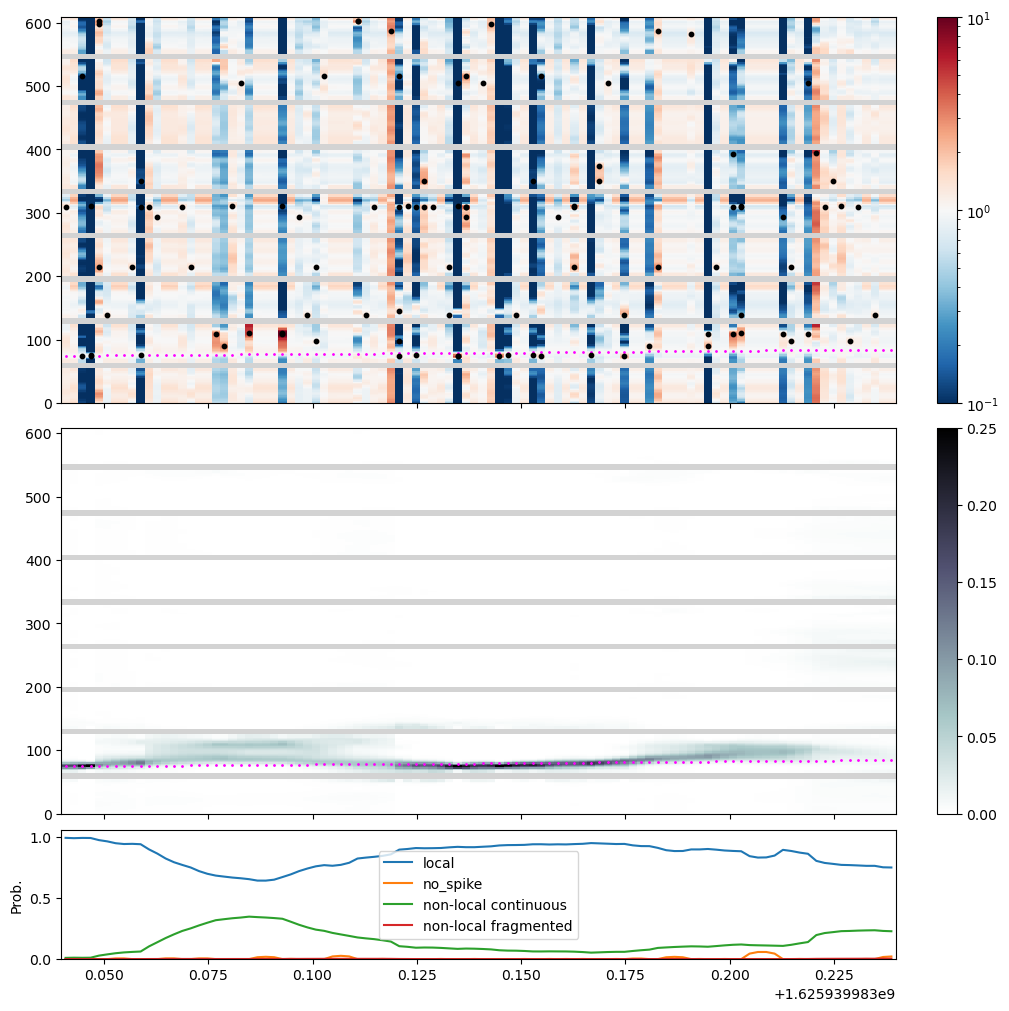

In [21]:
plot_likelihood_ratio(
    slice(231_400, 231_500),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    slice(231_400, 231_500),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

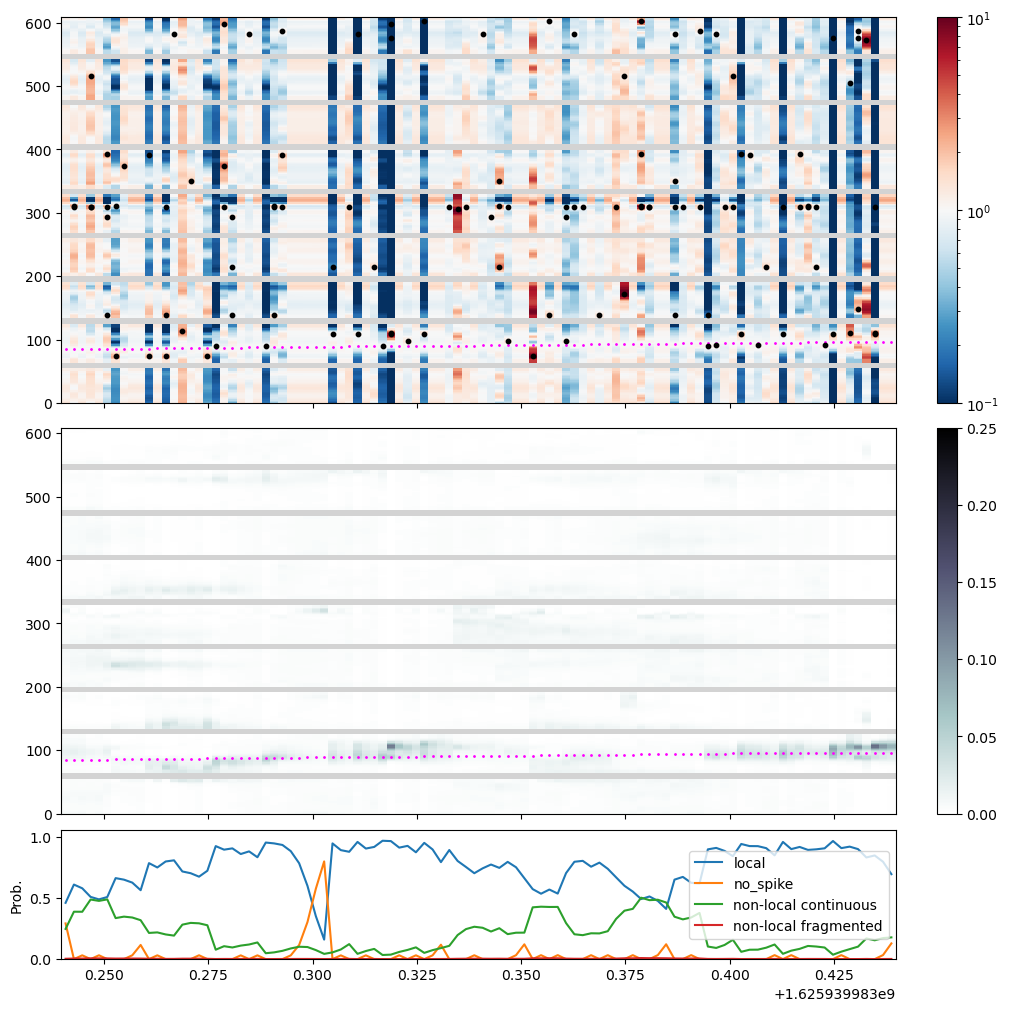

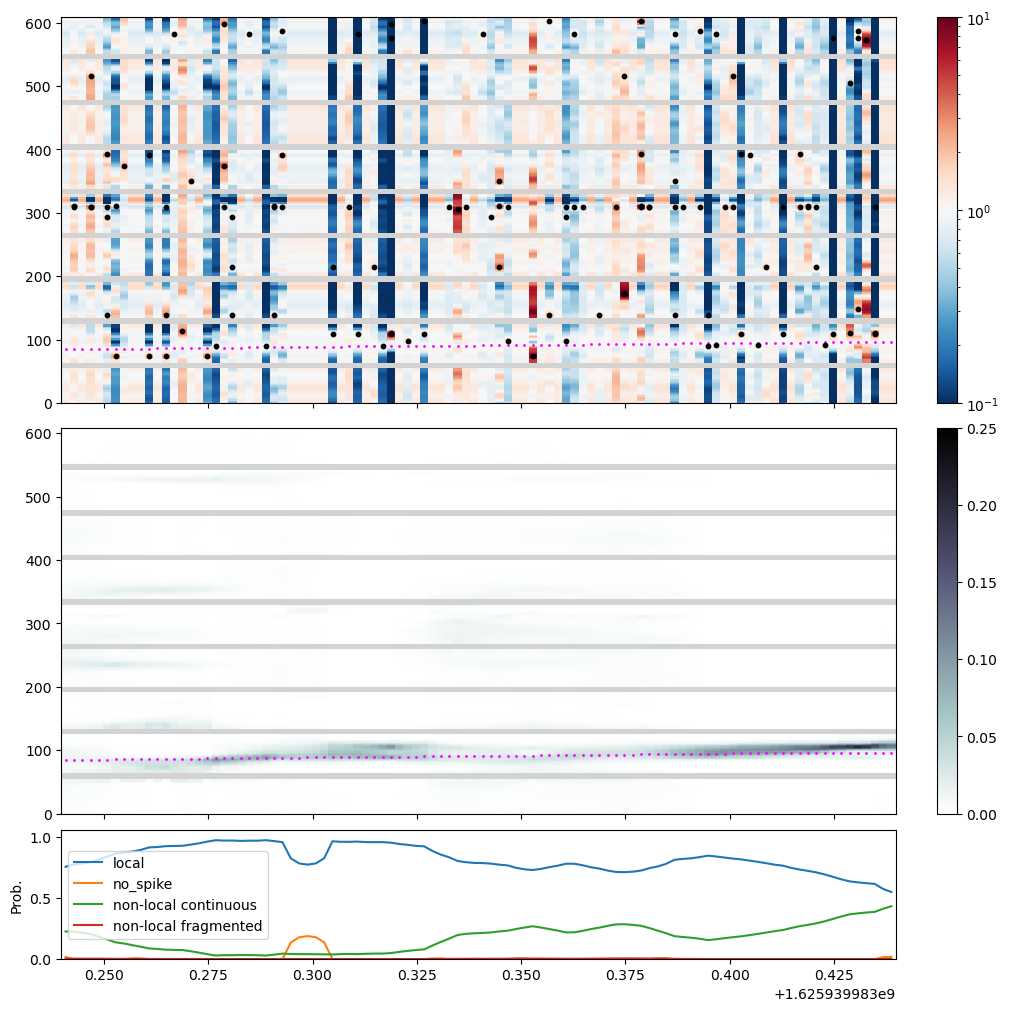

In [22]:
plot_likelihood_ratio(
    slice(231_500, 231_600),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    slice(231_500, 231_600),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

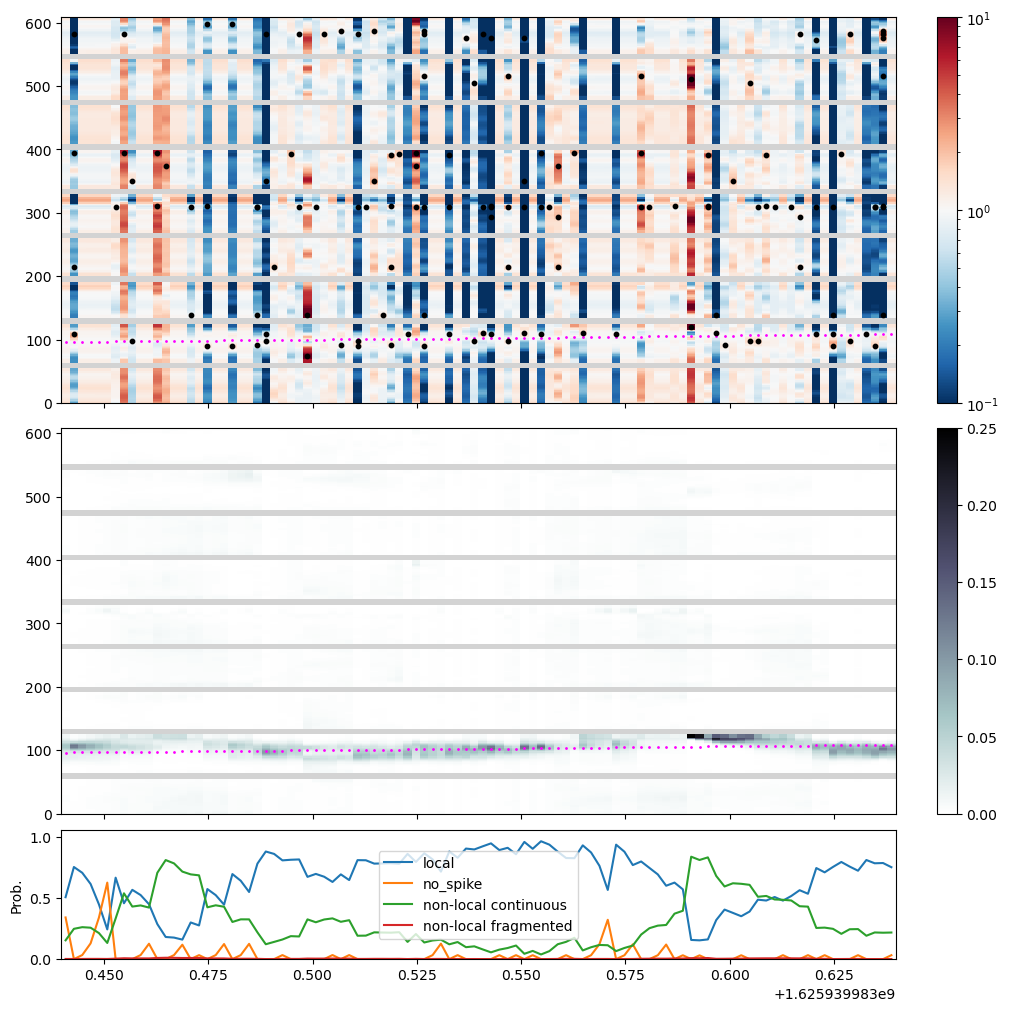

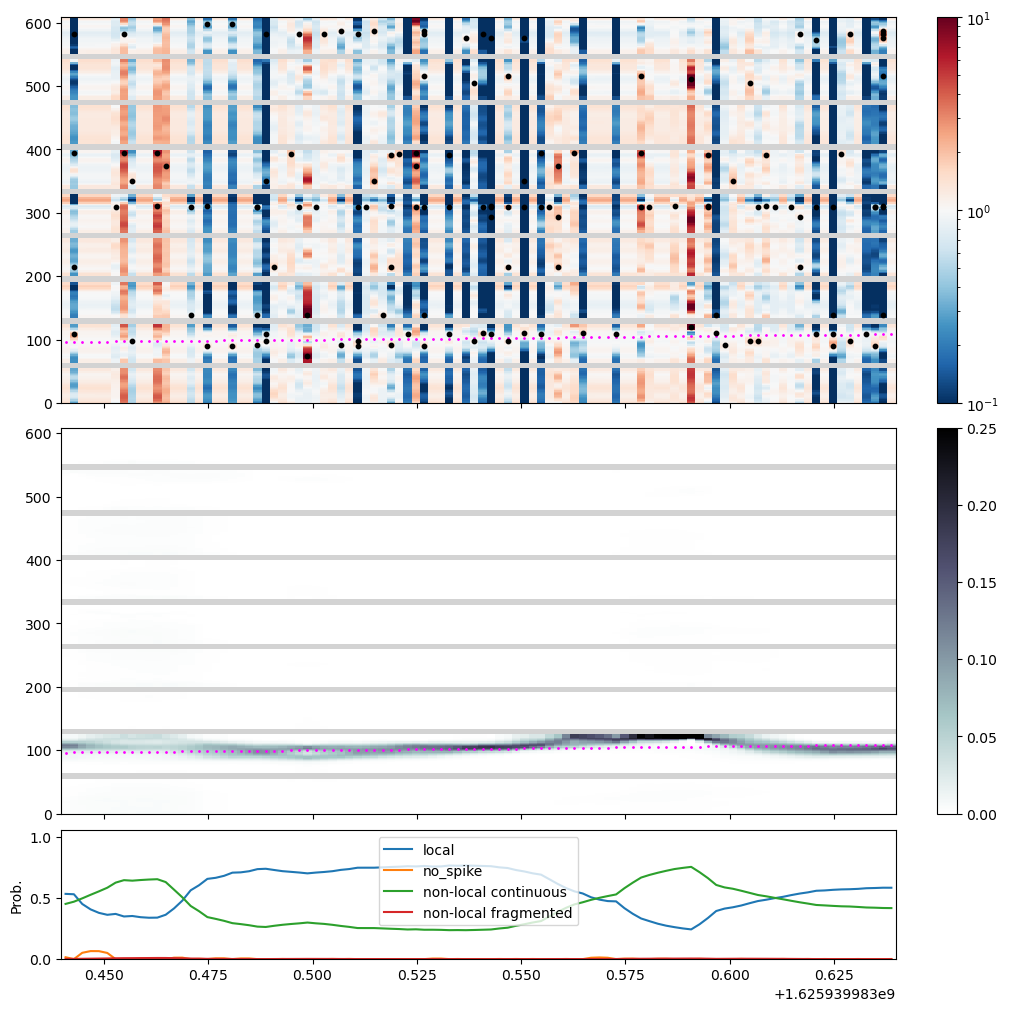

In [23]:
plot_likelihood_ratio(
    slice(231_600, 231_700),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    slice(231_600, 231_700),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

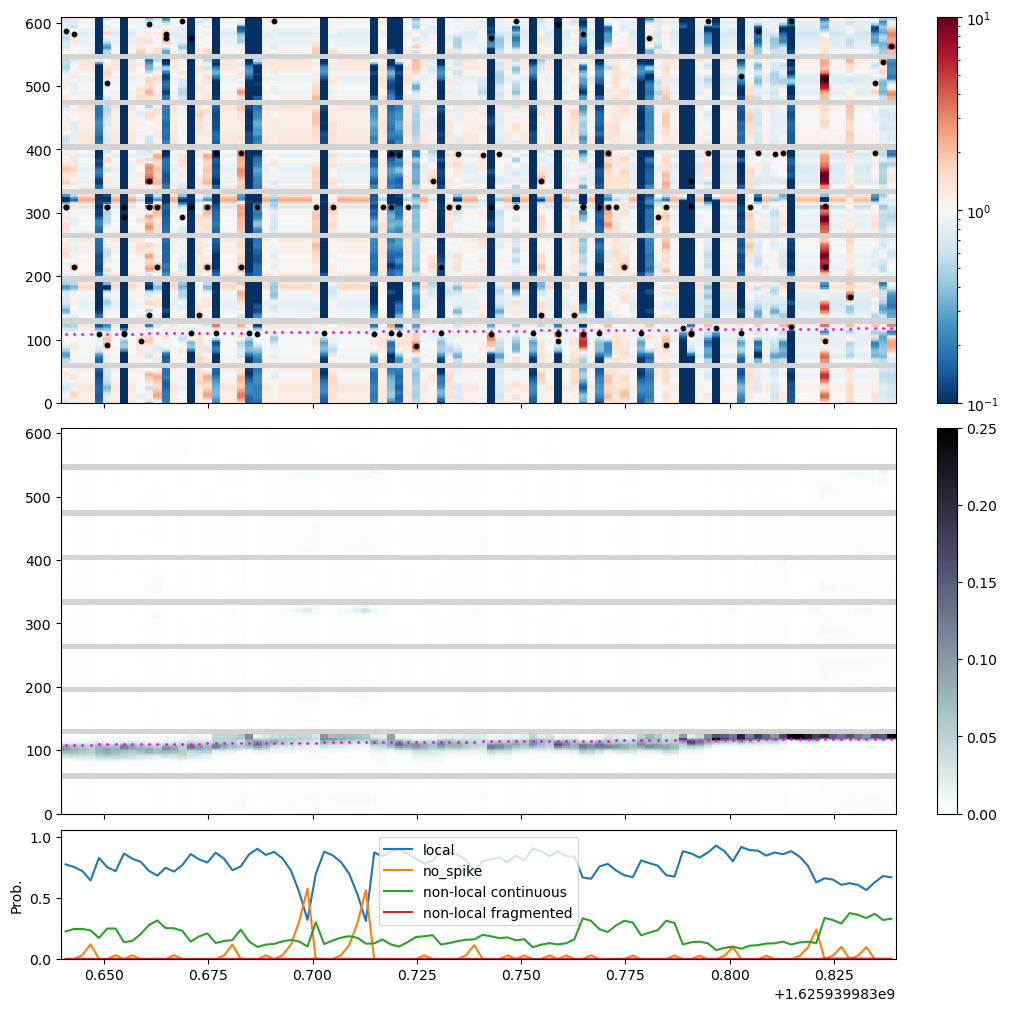

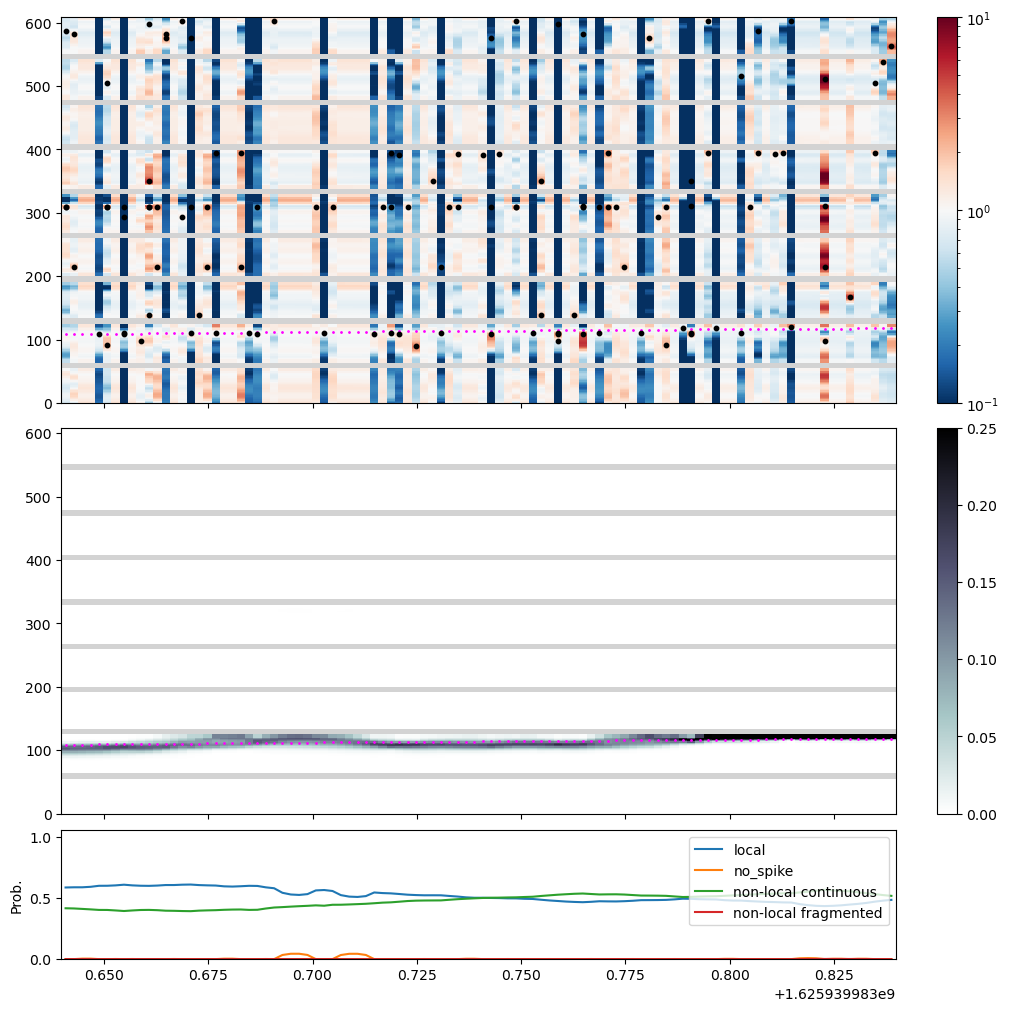

In [24]:
plot_likelihood_ratio(
    slice(231_700, 231_800),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    slice(231_700, 231_800),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

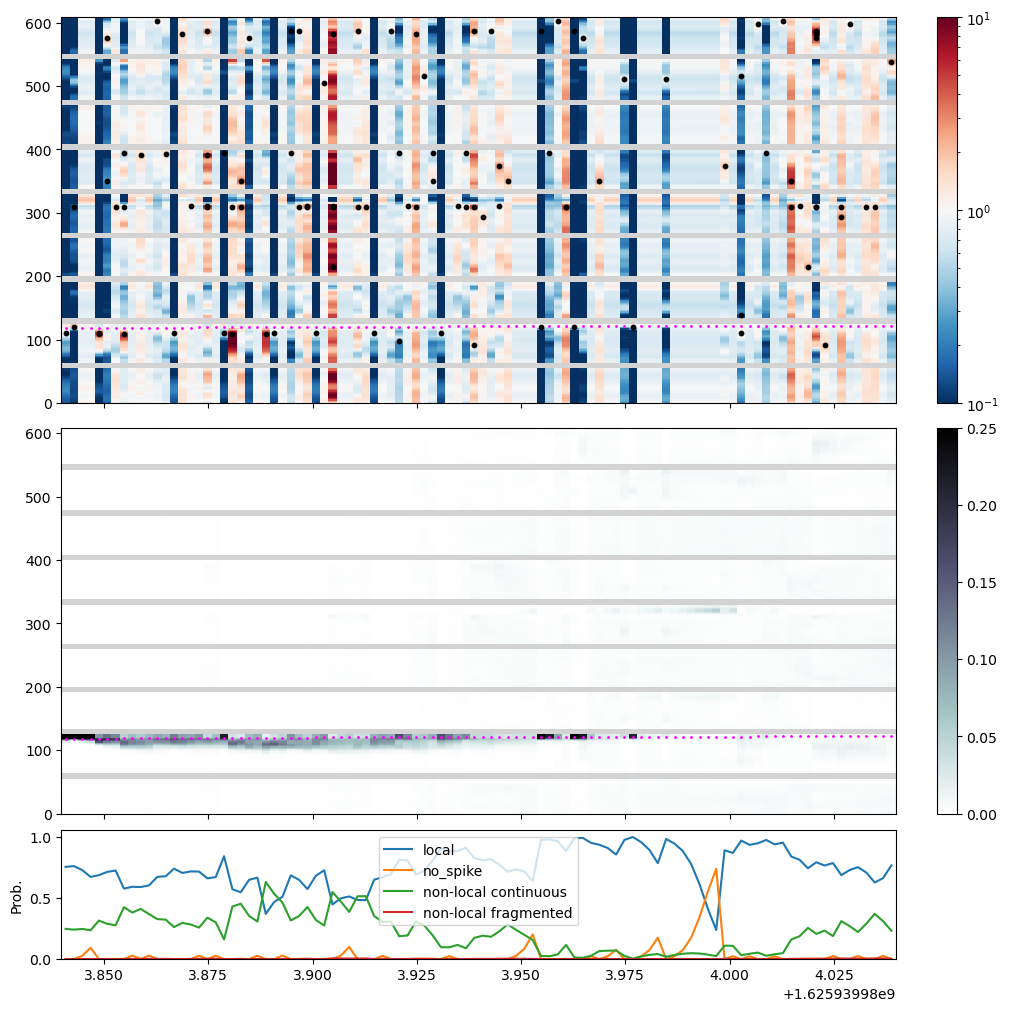

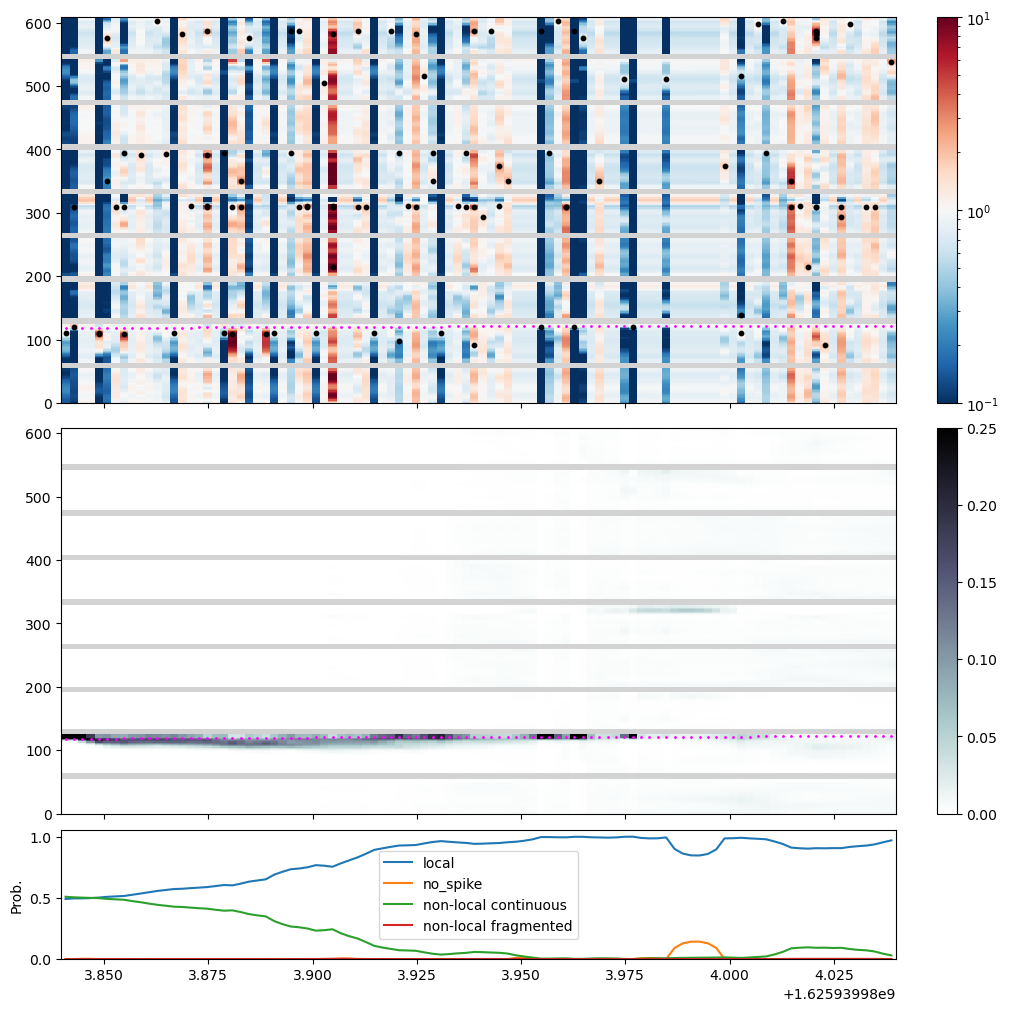

In [25]:
plot_likelihood_ratio(
    slice(231_800, 231_900),
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    slice(231_800, 231_900),
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

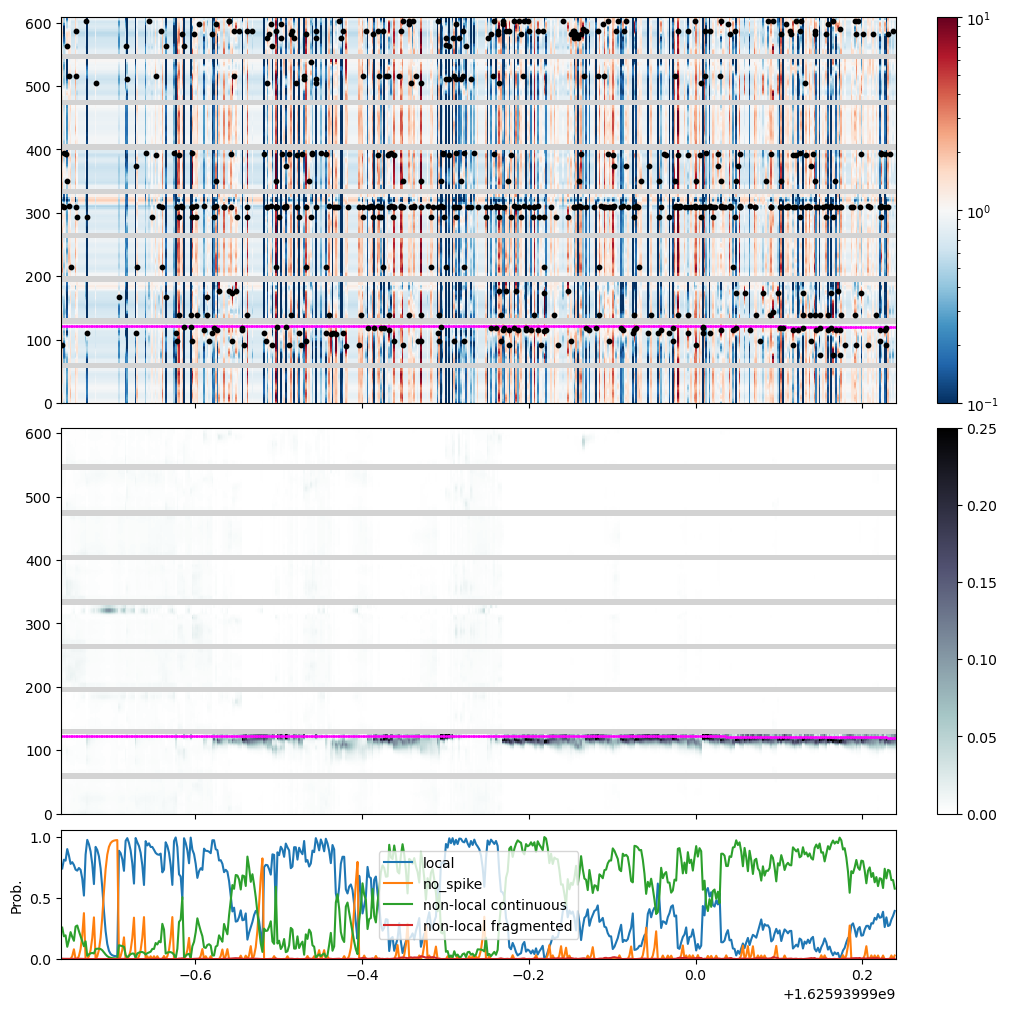

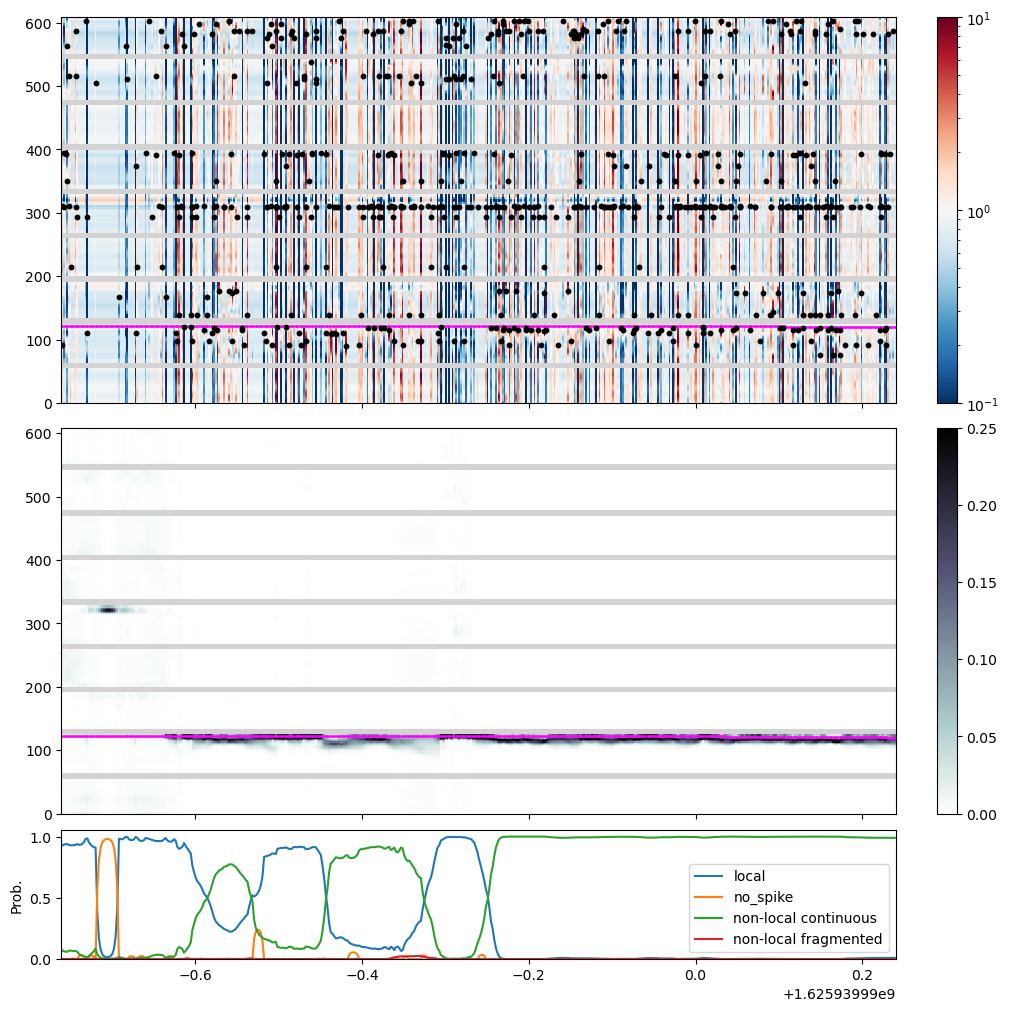

In [26]:
time_slice = slice(234_500, 235_000)
plot_likelihood_ratio(
    time_slice,
    log_likelihood,
    causal_posterior,
    causal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

plot_likelihood_ratio(
    time_slice,
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    non_local_rates,
    spikes,
    position,
    env,
    time,
    state_ind,
    state_names,
    figsize=(10, 10),
)

Text(0.5, 1.0, 'Discrete State Transition')

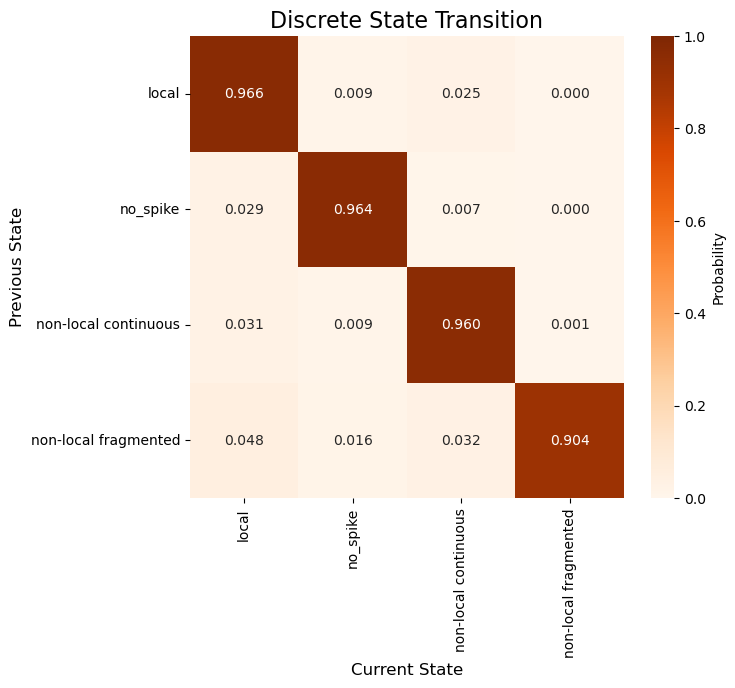

In [27]:
vmin, vmax, fmt = 0.0, 1.0, "0.03f"
label = "Probability"
cmap = "Oranges"

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(
    data=discrete_state_transitions,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=fmt,
    cmap=cmap,
    xticklabels=state_names,
    yticklabels=state_names,
    ax=ax,
    cbar_kws={"label": label},
)
ax.set_ylabel("Previous State", fontsize=12)
ax.set_xlabel("Current State", fontsize=12)
ax.set_title("Discrete State Transition", fontsize=16)